In [3]:
# Spatial tools
!pip install shapely contextily

# For elevation if needed (LiDAR DTM)
!pip install rasterio

In [4]:
# Core libraries
import pandas as pd
import geopandas as gpd
import numpy as np
import os

# Geometry and spatial ops
from shapely.geometry import Point, Polygon
import contextily as cx

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Modeling
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import classification_report, confusion_matrix, mean_squared_error, mean_absolute_error, r2_score
import xgboost as xgb

# Warnings and display
import warnings
warnings.filterwarnings('ignore')

In [5]:
egms_csv_dir = "Data/EGMS"

In [6]:
# Load and concatenate all CSV files
egms_df = pd.concat(
    [pd.read_csv(os.path.join(egms_csv_dir, f)) for f in os.listdir(egms_csv_dir)],
    ignore_index=True
)

# Convert to GeoDataFrame
geometry = [Point(xy) for xy in zip(egms_df['easting'], egms_df['northing'])]
egms_gdf = gpd.GeoDataFrame(egms_df, geometry=geometry, crs="EPSG:3035")

print("Total EGMS points loaded:", len(egms_gdf))
egms_gdf.head()

Total EGMS points loaded: 1993890


pid  easting  northing  height  rmse  mean_velocity  \
0  40eFbfgZ3g  3400050   3300450   331.1   2.8            0.3   
1  40eHQBeRjE  3400050   3302850   408.2   2.8            0.8   
2  40eLHHZweW  3400050   3307950   286.9   3.0           -1.0   
3  40eLa2EvQm  3400050   3308350   249.1   2.2            0.4   
4  40eLeiuAcq  3400050   3308450   251.6   2.6            0.4   

   mean_velocity_std  acceleration  acceleration_std  seasonality  ...  \
0                0.1         -1.56              0.18          0.4  ...   
1                0.1         -0.81              0.18          1.1  ...   
2                0.1          1.16              0.20          1.6  ...   
3                0.1          0.09              0.14          0.7  ...   
4                0.1          0.56              0.17          1.5  ...   

   20231031  20231106  20231112  20231118  20231124  20231130  20231206  \
0       5.2       3.8       2.9       3.5       4.2       4.6       5.6   
1       6.3       6.0       7.0       7.1       4.9       3.5       4.9   
2      -4.3      -4.5      -4.7       0.0       6.0       5.5       2.2   
3      -2.6      -2.5      -1.9       0.2       3.0       2.4      -0.9   
4      -7.0      -6.5      -6.9      -3.5       3.6       4.3      -1.0   

   20231212  20231218                 geometry  
0       5.4       4.0  POINT (3400050 3300450)  
1       6.3       6.6  POINT (3400050 3302850)  
2      -0.4      -2.1  POINT (3400050 3307950)  
3      -3.8      -5.8  POINT (3400050 3308350)  
4      -1.4       3.3  POINT (3400050 3308450)  

[5 rows x 313 columns]

In [7]:
cheshire = gpd.read_file("Data/cheshire_boundaries_fixed.gpkg")
print("Rows:", len(cheshire))
display(cheshire.head())

Rows: 4


LAD24CD                    LAD24NM LAD24NMW   BNG_E   BNG_N     LONG  \
0  E06000049              Cheshire East     None  380510  363462 -2.29300   
1  E06000050  Cheshire West and Chester     None  353097  363145 -2.70298   
2  E06000050  Cheshire West and Chester     None  353097  363145 -2.70298   
3  E06000050  Cheshire West and Chester     None  353097  363145 -2.70298   

       LAT                              GlobalID  \
0  53.1679  81091fd9-1548-48d7-a870-abf1cf45e9c3   
1  53.1634  d5807502-f19f-45fa-a16d-889f5fd83a09   
2  53.1634  d5807502-f19f-45fa-a16d-889f5fd83a09   
3  53.1634  d5807502-f19f-45fa-a16d-889f5fd83a09   

                                            geometry  
0  MULTIPOLYGON (((371858.1965 387837.902, 371862...  
1  MULTIPOLYGON (((327866.924 373722.305, 327869....  
2  MULTIPOLYGON (((326146.586 378216.579, 326143....  
3  MULTIPOLYGON (((367148.0982 382916.8006, 36714...

In [8]:

# Force set the known true CRS
cheshire = cheshire.set_crs(epsg=27700, allow_override=True)

# Now properly reproject to EPSG:3035
cheshire = cheshire.to_crs(epsg=3035)

# Check bounds
print("Cheshire bounds (now in EPSG:3035):", cheshire.total_bounds)


Cheshire bounds (now in EPSG:3035): [3451295.58561263 3387886.88473084 3525670.29698949 3435081.32608366]


In [9]:
egms_cheshire = gpd.sjoin(egms_gdf, cheshire, how="inner", predicate="within")
print("Points in Cheshire:", len(egms_cheshire))
egms_cheshire.to_file("Data/egms_points_in_cheshire.gpkg", driver="GPKG")

Points in Cheshire: 106338


In [10]:
import random

# If Cheshire has multiple polygons, unify them into one
cheshire_union = cheshire.dissolve()

# Sample 5 random points from the clipped EGMS
for i in range(5):
    sample = egms_cheshire.sample(1)
    pt = sample.geometry.iloc[0]
    # Check if the point is within the dissolved polygon
    is_inside = pt.within(cheshire_union.geometry.iloc[0])
    print(f"Sample point {pt}: Is inside Cheshire? {is_inside}")

Sample point POINT (3454750 3432050): Is inside Cheshire? True
Sample point POINT (3489550 3398650): Is inside Cheshire? True
Sample point POINT (3500450 3423050): Is inside Cheshire? True
Sample point POINT (3487950 3420050): Is inside Cheshire? True
Sample point POINT (3509650 3406950): Is inside Cheshire? True


In [11]:
! pip install mapclassify

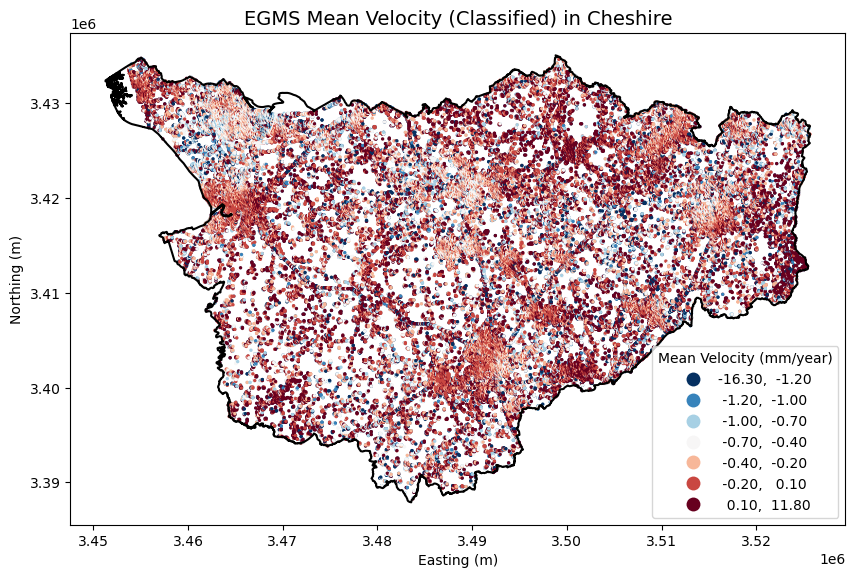

In [12]:

fig, ax = plt.subplots(figsize=(10, 8))

egms_cheshire.plot(
    ax=ax,
    column='mean_velocity',
    cmap='RdBu_r',           # diverging colormap: red=negative, blue=positive
    scheme='quantiles',      # splits data into quantile-based classes
    k=7,                     # number of classes
    legend=True,
    legend_kwds={
        'title': "Mean Velocity (mm/year)"
    },
    markersize=2
)

# Plot Cheshire boundary (dissolved)
cheshire_union = cheshire.dissolve()
cheshire_union.boundary.plot(ax=ax, color='black', linewidth=1.5)

ax.set_title("EGMS Mean Velocity (Classified) in Cheshire", fontsize=14)
ax.set_xlabel("Easting (m)")
ax.set_ylabel("Northing (m)")

plt.show()


# Suji

### Additional EDA

In [15]:
date_cols = egms_cheshire.columns[11:-10]
date_cols

Index(['20190113', '20190119', '20190125', '20190131', '20190206', '20190212',
       '20190218', '20190224', '20190302', '20190308',
       ...
       '20231025', '20231031', '20231106', '20231112', '20231118', '20231124',
       '20231130', '20231206', '20231212', '20231218'],
      dtype='object', length=301)

In [43]:
var_cols = egms_cheshire.columns[:11]
var_cols

Index(['pid', 'easting', 'northing', 'height', 'rmse', 'mean_velocity',
       'mean_velocity_std', 'acceleration', 'acceleration_std', 'seasonality',
       'seasonality_std'],
      dtype='object')

In [16]:
date_index = pd.to_datetime(date_cols, format="%Y%m%d")

# Mean displacement (Series)
monthly_displacement = egms_cheshire[date_cols].mean()

monthly_displacement.index = date_index
monthly_mean = monthly_displacement.resample('M').mean()

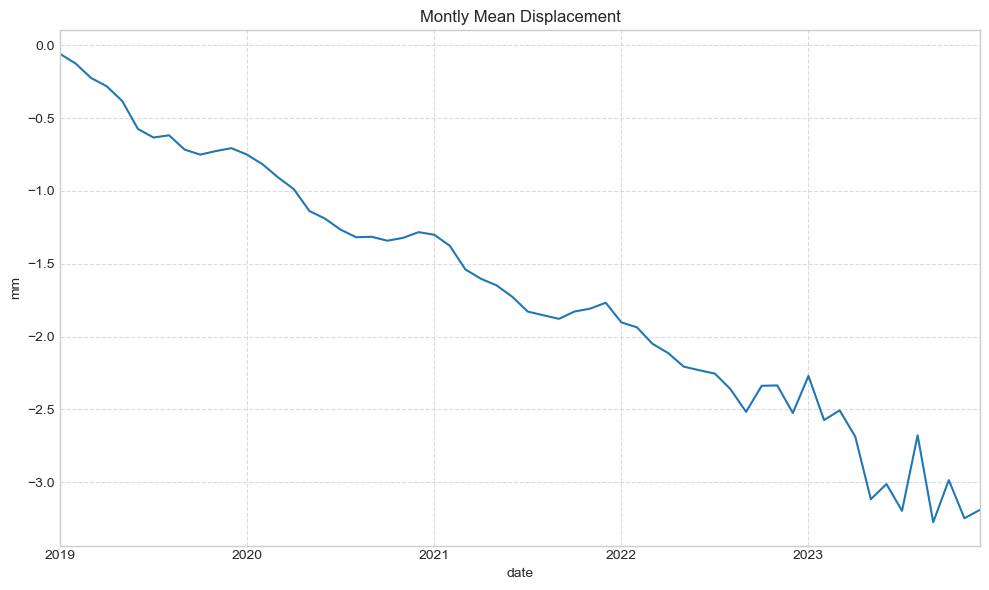

In [17]:
import warnings

warnings.filterwarnings("ignore", category=UserWarning)

plt.style.use('seaborn-v0_8-whitegrid')
monthly_mean.plot(title='Montly Mean Displacement', ylabel='mm', xlabel='date', figsize=(10, 6))
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

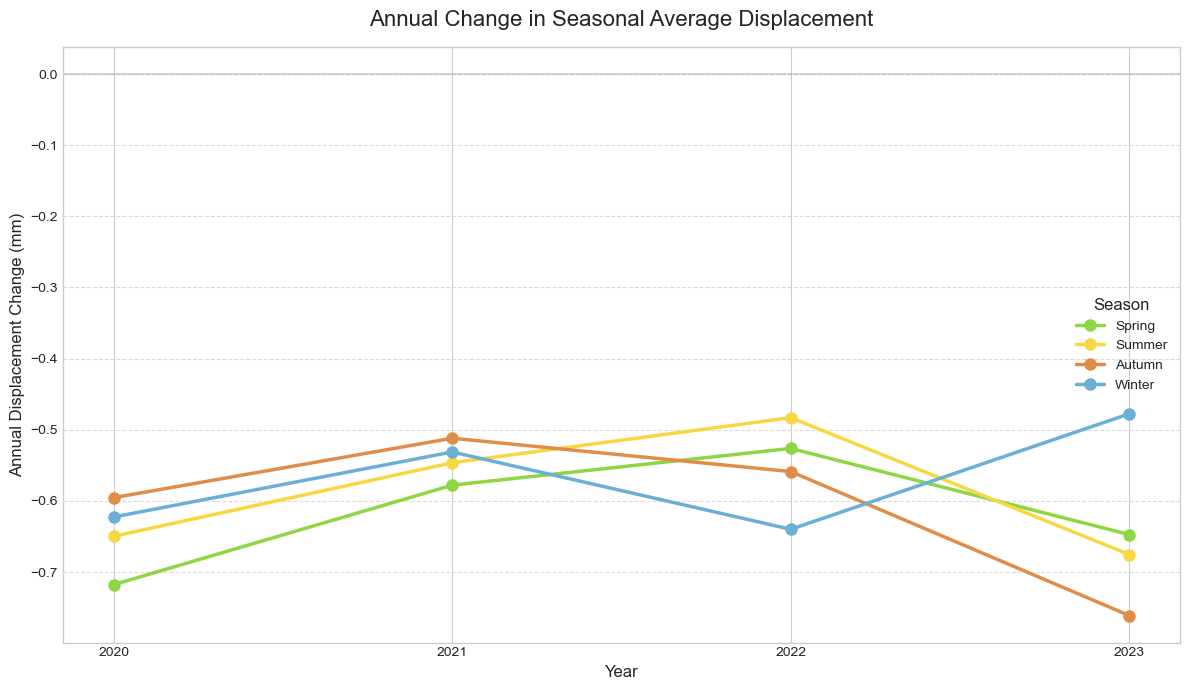

In [18]:
avg_displacement = egms_cheshire[egms_cheshire.columns[11:-10]].select_dtypes(include='number').mean()
avg_displacement.index = date_index

def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Autumn'

season_df = pd.DataFrame({'displacement': avg_displacement})
season_df['season'] = season_df.index.month.map(get_season)
season_df['year'] = season_df.index.year
seasonal_avg = season_df.groupby(['year', 'season'])['displacement'].mean().unstack()
seasonal_avg = seasonal_avg[['Spring', 'Summer', 'Autumn', 'Winter']]

# Annual difference
seasonal_diff = seasonal_avg.diff()
seasonal_diff = seasonal_diff.dropna(how='all')

plt.figure(figsize=(12, 7))

colors = {'Spring': '#8dd644', 'Summer': '#f7d842', 'Autumn': '#e08d49', 'Winter': '#6baed6'}
for season in seasonal_diff.columns:
    plt.plot(seasonal_diff.index, seasonal_diff[season], marker='o', linewidth=2.5, 
             label=season, color=colors[season], markersize=8)

plt.axhline(y=0, color='gray', linestyle='-', alpha=0.3)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.title('Annual Change in Seasonal Average Displacement', fontsize=16, pad=15)
plt.ylabel('Annual Displacement Change (mm)', fontsize=12)
plt.xlabel('Year', fontsize=12)
plt.legend(title='Season', fontsize=10, title_fontsize=12)

plt.xticks(seasonal_diff.index, seasonal_diff.index, rotation=0, fontsize=10)

plt.tight_layout()
plt.show()

## RMSE
* LiDAR data or satellite-based surface displacement data like EGMS inherently contain errors due to factors such as sensor accuracy, terrain conditions, and climate influences. These errors are often represented by the Root Mean Square Error (RMSE) value, which is used to assess the quality or reliability of interpolation.



Text(0, 0.5, 'Number of Points')

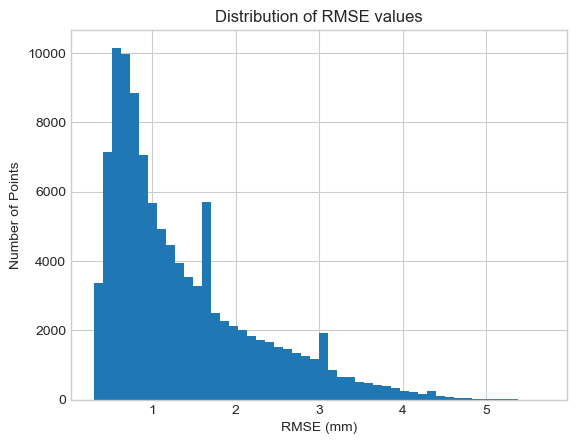

In [20]:
egms_cheshire['rmse'].hist(bins=50)
plt.title('Distribution of RMSE values')
plt.xlabel('RMSE (mm)')
plt.ylabel('Number of Points')

In [21]:
# If there are many locations where the RMSE is 5 or higher, it implies that there are many areas with lower data quality. -> Not many!

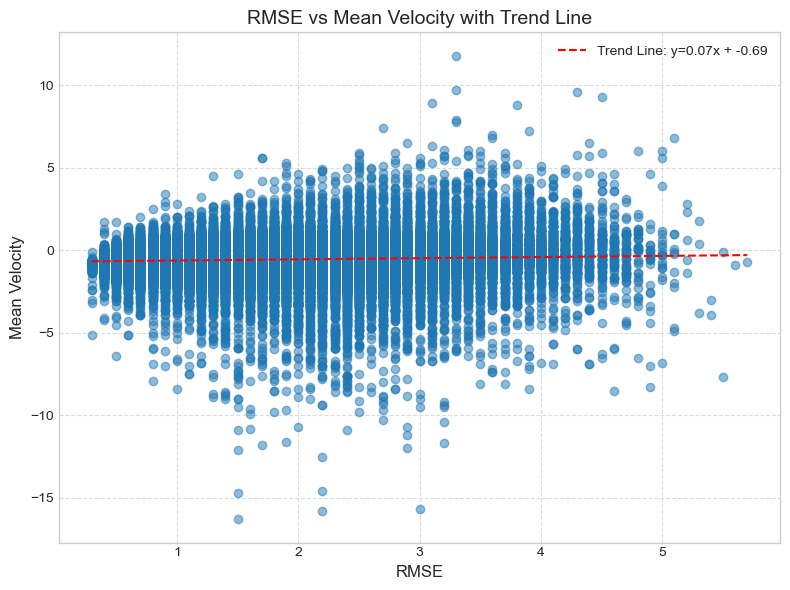

In [22]:
import numpy as np

rmse = egms_cheshire['rmse']
mean_velocity = egms_cheshire['mean_velocity']

coefficients = np.polyfit(rmse, mean_velocity, 1)
polynomial = np.poly1d(coefficients)
rmse_sorted = np.sort(rmse)

plt.figure(figsize=(8, 6))
plt.scatter(rmse, mean_velocity, alpha=0.5)
plt.plot(rmse_sorted, polynomial(rmse_sorted), color='red', linestyle='--', label=f'Trend Line: y={coefficients[0]:.2f}x + {coefficients[1]:.2f}')

plt.title('RMSE vs Mean Velocity with Trend Line', fontsize=14)
plt.xlabel('RMSE', fontsize=12)
plt.ylabel('Mean Velocity', fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

If the mean velocity is significantly high in areas with high RMSE (Root Mean Square Error), it could indicate a potential error.
<br><br>
RMSE vs Mean Velocity Relationshop
: Spots generally distributed widely and evenly
-> No significant correaltion
<br><br>
: Tilt of the regression line is almost horizon (low positive correlation)
-> interpolation X

         Type HS2_Phase                   HS2_DocNum HS2_DocRev HS2_RevDat  \
0  Embankment        R2  2RS02-WSP-GI-GDD-000-000011        P02 2018-10-24   
1     Viaduct        R2  2RS02-WSP-GI-GDD-000-000011        P02 2018-10-24   
2     Cutting        R2  2RS02-WSP-GI-GDD-000-000011        P02 2018-10-24   
3    At Grade        R2  2RS02-WSP-GI-GDD-000-000011        P02 2018-10-24   
4     Viaduct        R2  2RS02-WSP-GI-GDD-000-000011        P02 2018-10-24   

  Currency Baseline HS2_ValidF HS2_ValidT  OBJECTID  Shape__Len  \
0     None     WDES 2018-10-10       None         1  669.999942   
1     None     WDES 2018-10-10       None         2  584.000006   
2     None     WDES 2018-10-10       None         3  916.999896   
3     None     WDES 2018-10-10       None         4  109.999966   
4     None     WDES 2018-10-10       None         5  213.000005   

                                            geometry  
0  LINESTRING Z (446872.756 355256.463 118.466, 4...  
1  LINESTRING Z (4

<Axes: >

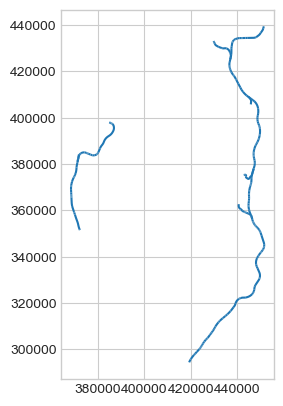

In [24]:
import geopandas as gpd

shapefile_path = "Data/HS2_Route_Detailed.shp"
gdf = gpd.read_file(shapefile_path)

print(gdf.head())
gdf.plot()

In [25]:
print("Cheshire CRS:", cheshire.crs)
print("GDF CRS:", gdf.crs)


Cheshire CRS: EPSG:3035
GDF CRS: EPSG:27700


In [26]:
if cheshire.crs != gdf.crs:
    gdf = gdf.to_crs(cheshire.crs)

gdf_filtered = gdf[gdf.geometry.intersects(cheshire.unary_union)]
print(f"Filtered features: {len(gdf_filtered)}")

Filtered features: 65


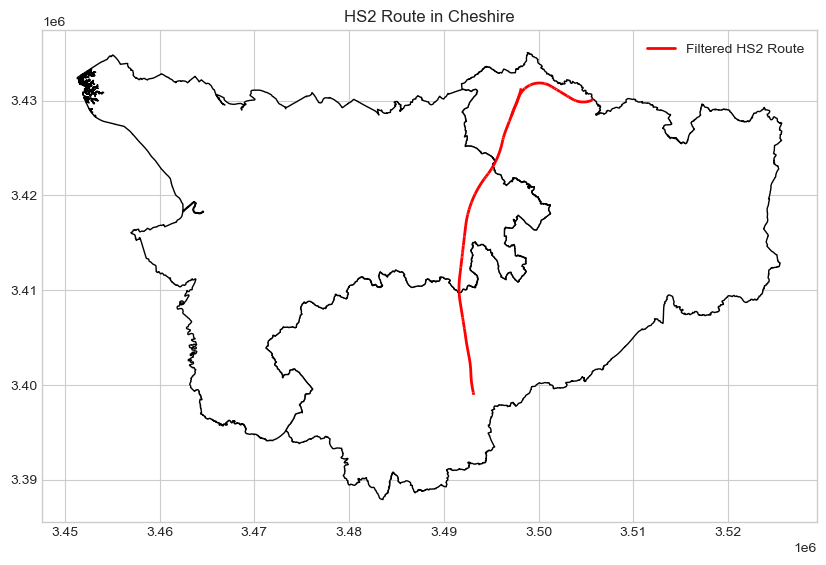

In [27]:
fig, ax = plt.subplots(figsize=(10, 10))

cheshire.plot(ax=ax, color='white', edgecolor='black', aspect='equal')

gdf_filtered = gdf[gdf.geometry.within(cheshire.unary_union)]
gdf_filtered.plot(ax=ax, color='red', linewidth=2)

# Add a proxy artist for the legend
from matplotlib.lines import Line2D
legend_elements = [Line2D([0], [0], color='red', lw=2, label='Filtered HS2 Route')]
ax.legend(handles=legend_elements)

plt.title("HS2 Route in Cheshire")
plt.show()

## Groundwater data inspection

* https://www.bgs.ac.uk/datasets/hydrogeology-625k/#download

   OBJECTID        ROCK_UNIT CLASS                              CHARACTER  \
0       1.0  GAULT FORMATION     3  Rocks with essentially no groundwater   
1       2.0  GAULT FORMATION     3  Rocks with essentially no groundwater   
2       3.0  GAULT FORMATION     3  Rocks with essentially no groundwater   
3       4.0  GAULT FORMATION     3  Rocks with essentially no groundwater   
4       5.0  GAULT FORMATION     3  Rocks with essentially no groundwater   

  FLOW_MECHA                                            SUMMARY  \
0       None  Low permeability clays up to 100 m thick separ...   
1       None  Low permeability clays up to 100 m thick separ...   
2       None  Low permeability clays up to 100 m thick separ...   
3       None  Low permeability clays up to 100 m thick separ...   
4       None  Low permeability clays up to 100 m thick separ...   

                 VERSION                                           geometry  
0  HydrogeologyUK_IoM_v5  POLYGON ((375580.729 136350.03

<Axes: >

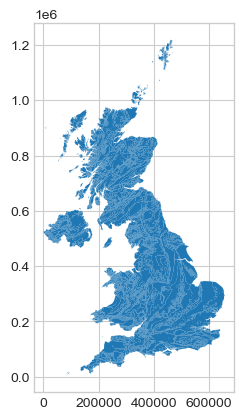

In [29]:
shapefile_path = "Data/HydrogeologyUK_IoM_v5.shp"
gwdf = gpd.read_file(shapefile_path)

print(gwdf.head())
gwdf.plot()

In [30]:
gwdf

OBJECTID                  ROCK_UNIT CLASS  \
0           1.0            GAULT FORMATION     3   
1           2.0            GAULT FORMATION     3   
2           3.0            GAULT FORMATION     3   
3           4.0            GAULT FORMATION     3   
4           5.0            GAULT FORMATION     3   
...         ...                        ...   ...   
13777   13780.0        GREY CHALK SUBGROUP    2A   
13778   13781.0       FELL SANDSTONE GROUP    1B   
13779   13782.0  UPPER GREENSAND FORMATION    1B   
13780   13783.0  UPPER GREENSAND FORMATION    1B   
13781       0.0               ARGYLL GROUP    2C   

                                   CHARACTER  \
0      Rocks with essentially no groundwater   
1      Rocks with essentially no groundwater   
2      Rocks with essentially no groundwater   
3      Rocks with essentially no groundwater   
4      Rocks with essentially no groundwater   
...                                      ...   
13777              Highly productive aquifer   
13778          Moderately productive aquifer   
13779          Moderately productive aquifer   
13780          Moderately productive aquifer   
13781               Low productivity aquifer   

                                              FLOW_MECHA  \
0                                                   None   
1                                                   None   
2                                                   None   
3                                                   None   
4                                                   None   
...                                                  ...   
13777  Flow is virtually all through fractures and ot...   
13778                     Significant intergranular flow   
13779                     Significant intergranular flow   
13780                     Significant intergranular flow   
13781  Flow is virtually all through fractures and ot...   

                                                 SUMMARY  \
0      Low permeability clays up to 100 m thick separ...   
1      Low permeability clays up to 100 m thick separ...   
2      Low permeability clays up to 100 m thick separ...   
3      Low permeability clays up to 100 m thick separ...   
4      Low permeability clays up to 100 m thick separ...   
...                                                  ...   
13777  Marly Chalk aquifer that can yield up to 5 L/s...   
13778  Locally important aquifer up to 300 m thick wi...   
13779  Glauconitic sands yielding up to 25 L/s and of...   
13780  Glauconitic sands yielding up to 25 L/s and of...   
13781  Small amounts of groundwater in near surface w...   

                     VERSION  \
0      HydrogeologyUK_IoM_v5   
1      HydrogeologyUK_IoM_v5   
2      HydrogeologyUK_IoM_v5   
3      HydrogeologyUK_IoM_v5   
4      HydrogeologyUK_IoM_v5   
...                      ...   
13777  HydrogeologyUK_IoM_v5   
13778  HydrogeologyUK_IoM_v5   
13779  HydrogeologyUK_IoM_v5   
13780  HydrogeologyUK_IoM_v5   
13781  HydrogeologyUK_IoM_v5   

                                                geometry  
0      POLYGON ((375580.729 136350.037, 375580.729 13...  
1      POLYGON ((375485.561 136836.469, 375320.374 13...  
2      POLYGON ((376093.57 137664.384, 376241.63 1378...  
3      POLYGON ((376550.074 138041.592, 376301.712 13...  
4      POLYGON ((379894.016 141392.928, 379842.272 14...  
...                                                  ...  
13777  POLYGON ((532326.047 153483.259, 532322.385 15...  
13778  POLYGON ((398833.756 653488.222, 398869.75 653...  
13779  POLYGON ((330238.894 105467.454, 330238.899 10...  
13780  POLYGON ((330238.894 105467.454, 330101.054 10...  
13781  POLYGON ((87154.141 565436.698, 87252.127 5653...  

[13782 rows x 8 columns]

In [31]:
gwdf['CHARACTER'].unique()

array(['Rocks with essentially no groundwater',
       'Moderately productive aquifer', 'Low productivity aquifer',
       'Highly productive aquifer', 'Low productive aquifer'],
      dtype=object)

In [32]:
gwdf['FLOW_MECHA'].unique()

array([None, 'Significant intergranular flow',
       'Flow is virtually all through fractures and other discontinuities'],
      dtype=object)

In [33]:
if cheshire.crs != gwdf.crs:
    gwdf = gwdf.to_crs(cheshire.crs)

gwdf_filtered = gwdf[gwdf.geometry.intersects(cheshire.unary_union)]
print(f"Filtered features: {len(gwdf_filtered)}")

Filtered features: 38


In [34]:
gwdf_filtered.head()

OBJECTID                           ROCK_UNIT CLASS  \
1092    1093.0    PERMIAN ROCKS (UNDIFFERENTIATED)    1A   
1875    1876.0  DINANTIAN ROCKS (UNDIFFERENTIATED)    2B   
3341    3342.0                MILLSTONE GRIT GROUP    2B   
3907    3908.0   TRIASSIC ROCKS (UNDIFFERENTIATED)    1A   
4228    4229.0                          LIAS GROUP     3   

                                  CHARACTER  \
1092              Highly productive aquifer   
1875          Moderately productive aquifer   
3341          Moderately productive aquifer   
3907              Highly productive aquifer   
4228  Rocks with essentially no groundwater   

                                             FLOW_MECHA  \
1092                     Significant intergranular flow   
1875  Flow is virtually all through fractures and ot...   
3341  Flow is virtually all through fractures and ot...   
3907                     Significant intergranular flow   
4228                                               None   

                                                SUMMARY  \
1092  Sandstone, with some conglomerates, aquifer yi...   
1875  Massive karstic limestone aquifer with rapid r...   
3341  Regionally significant multi-layered aquifer u...   
3907  Principal sandstone aquifer up to 600 m thick ...   
4228  Largely mudstone sequence with limestone and M...   

                    VERSION                                           geometry  
1092  HydrogeologyUK_IoM_v5  POLYGON ((3455630.409 3429229.915, 3455371.634...  
1875  HydrogeologyUK_IoM_v5  POLYGON ((3507469.914 3403845.68, 3507948.635 ...  
3341  HydrogeologyUK_IoM_v5  POLYGON ((3523395.872 3428198.174, 3523162.563...  
3907  HydrogeologyUK_IoM_v5  POLYGON ((3516443.444 3405982.32, 3516223.017 ...  
4228  HydrogeologyUK_IoM_v5  POLYGON ((3479024.302 3399077.151, 3475595.521...

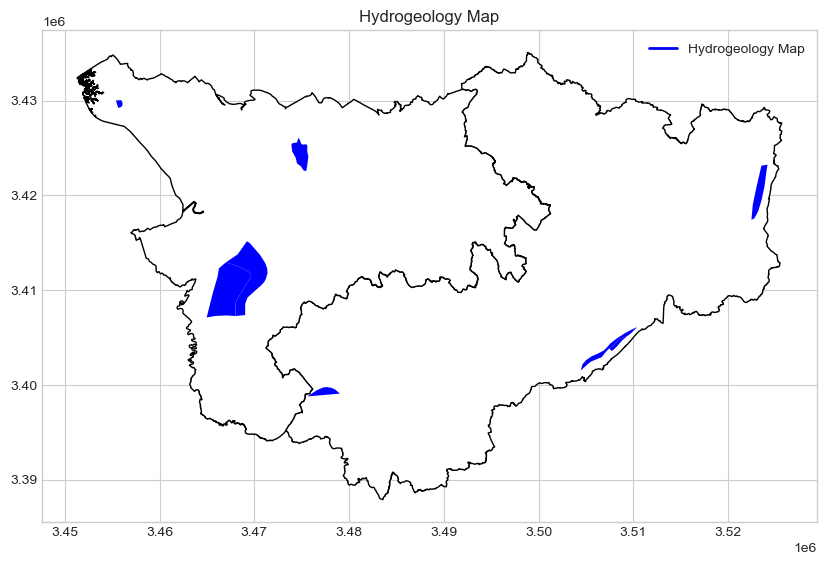

In [35]:
fig, ax = plt.subplots(figsize=(10, 10))

cheshire.plot(ax=ax, color='white', edgecolor='black', aspect='equal')

gwdf_filtered = gwdf[gwdf.geometry.within(cheshire.unary_union)]
gwdf_filtered.plot(ax=ax, color='blue', linewidth=2)

# Add a proxy artist for the legend
from matplotlib.lines import Line2D
legend_elements = [Line2D([0], [0], color='blue', lw=2, label='Hydrogeology Map')]
ax.legend(handles=legend_elements)

plt.title("Hydrogeology Map")
plt.show()

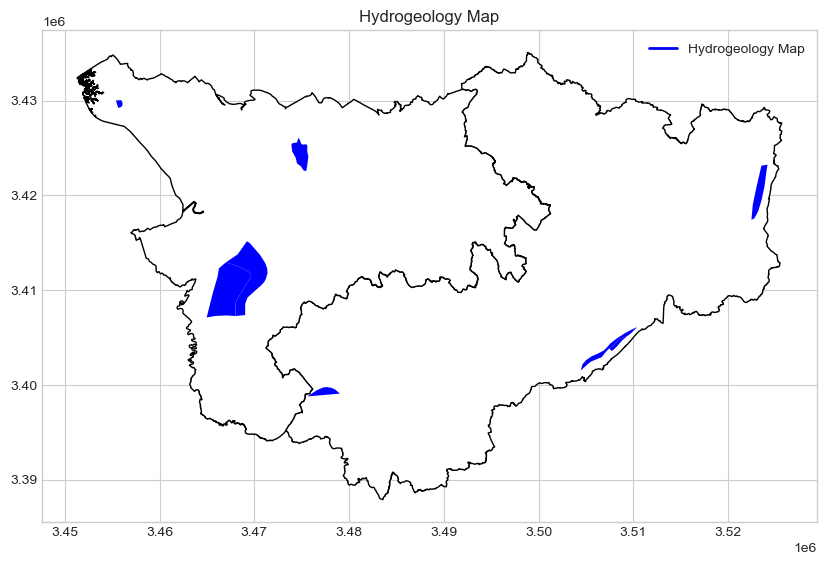

Number of unique CHARACTER values: 4


NameError: name 'mcolors' is not defined

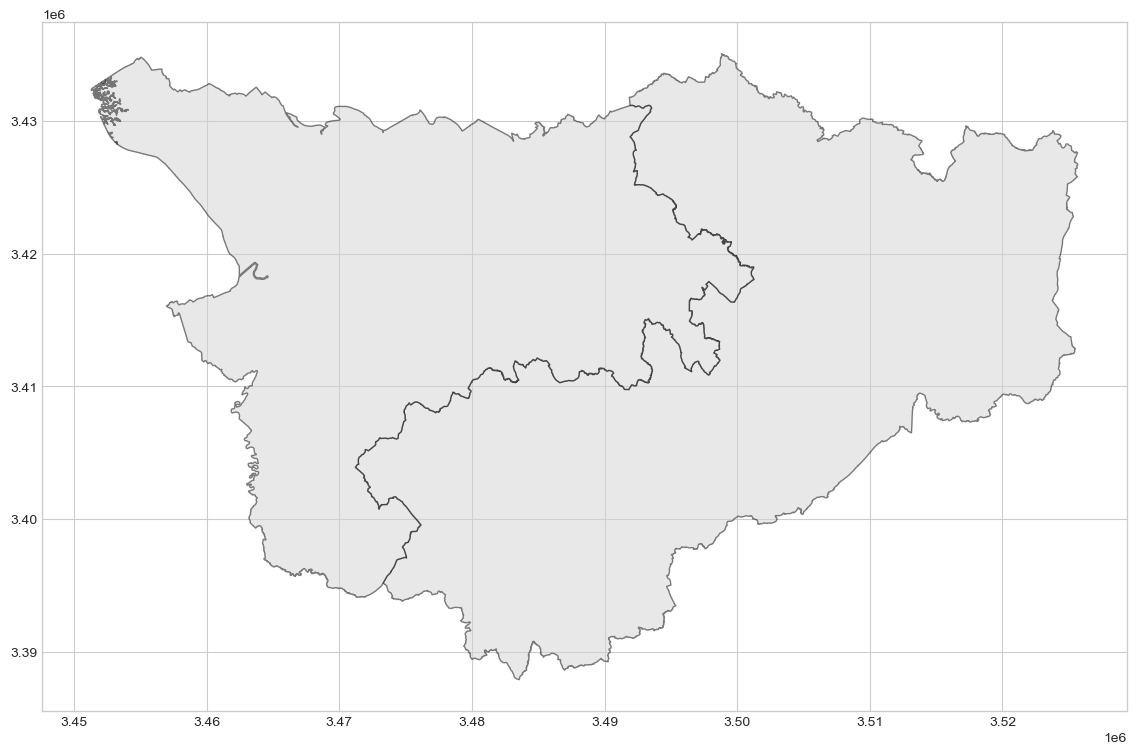

In [36]:
from matplotlib.lines import Line2D
from matplotlib.patches import Patch

fig, ax = plt.subplots(figsize=(10, 10))
cheshire.plot(ax=ax, color='white', edgecolor='black', aspect='equal')
gwdf_filtered = gwdf[gwdf.geometry.within(cheshire.unary_union)]
gwdf_filtered.plot(ax=ax, color='blue', linewidth=2)
legend_elements = [Line2D([0], [0], color='blue', lw=2, label='Hydrogeology Map')]
ax.legend(handles=legend_elements)
plt.title("Hydrogeology Map")
plt.show()

grouped_by = gwdf_filtered.groupby('CHARACTER')
unique_characters = gwdf_filtered['CHARACTER'].unique() 
print(f"Number of unique CHARACTER values: {len(unique_characters)}")

fig, ax = plt.subplots(figsize=(14, 10))
cheshire.plot(ax=ax, color='lightgrey', edgecolor='black', alpha=0.5)

colors = list(mcolors.TABLEAU_COLORS.values())

legend_elements = []
for i, char_value in enumerate(unique_characters):
    # Select only records with this CHARACTER
    char_data = gwdf_filtered[gwdf_filtered['CHARACTER'] == char_value] # 변경: 'CLASS' -> 'CHARACTER'

    # Plot this CHARACTER with a specific color
    color = colors[i % len(colors)]
    char_data.plot(ax=ax, color=color, edgecolor='black', alpha=0.7)

    # Create a legend entry for this CHARACTER
    legend_elements.append(Patch(facecolor=color, edgecolor='black',
                                label=f'Character {char_value}')) # 변경: 'Class' -> 'Character'

# Add the legend with our manually created elements
ax.legend(handles=legend_elements, loc='upper right')

plt.title("Hydrogeology in Cheshire by Summary Type", fontsize=14)
plt.tight_layout()

plt.savefig('Hydrogeology.png')

plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))
cheshire.plot(ax=ax, color='white', edgecolor='black', aspect='equal')
gwdf_filtered = gwdf[gwdf.geometry.within(cheshire.unary_union)]
gwdf_filtered.plot(ax=ax, color='blue', linewidth=2)
legend_elements = [Line2D([0], [0], color='blue', lw=2, label='Hydrogeology Map')]
ax.legend(handles=legend_elements)
plt.title("Hydrogeology Map")
plt.show()

grouped_by = gwdf_filtered.groupby('CLASS') #'CHARACTER' -> 'CLASS'
unique_classes = gwdf_filtered['CLASS'].unique() 
print(f"Number of unique CLASS values: {len(unique_classes)}")

fig, ax = plt.subplots(figsize=(14, 10))
cheshire.plot(ax=ax, color='lightgrey', edgecolor='black', alpha=0.5)

colors = list(mcolors.TABLEAU_COLORS.values())

legend_elements = []
for i, class_value in enumerate(unique_classes):
    # Select only records with this CLASS
    class_data = gwdf_filtered[gwdf_filtered['CLASS'] == class_value]

    # Plot this CLASS with a specific color
    color = colors[i % len(colors)]
    class_data.plot(ax=ax, color=color, edgecolor='black', alpha=0.7)

    # Create a legend entry for this CLASS
    legend_elements.append(Patch(facecolor=color, edgecolor='black',
                                label=f'Class {class_value}'))

# Add the legend with our manually created elements
ax.legend(handles=legend_elements, loc='upper right')

plt.title("Hydrogeology in Cheshire by Summary Type", fontsize=14)
plt.tight_layout()
plt.show()

# ML Model cross-check

## 1) Data Preprocessing

In [370]:
var_cols

Index(['pid', 'easting', 'northing', 'height', 'rmse', 'mean_velocity',
       'mean_velocity_std', 'acceleration', 'acceleration_std', 'seasonality',
       'seasonality_std'],
      dtype='object')

In [373]:
##### Step 1) to 3) #####

displacement_cols = [col for col in egms_cheshire.columns if col.isdigit()]
base_cols = ["pid", "easting", "northing", "height", "mean_velocity", "acceleration", "rmse", "seasonality"]   # "seasonality": included
all_cols = base_cols + displacement_cols
existing_cols = [col for col in all_cols if col in egms_cheshire.columns]
egms_clean = egms_cheshire[existing_cols].copy()
egms_clean

pid  easting  northing  height  mean_velocity  acceleration  \
72347    40fRTzd0L4  3464250   3398150    36.8           -1.3         -0.04   
72452    40fQZje40J  3464350   3396950    21.9           -0.9         -0.13   
72454    40fR1rdXAh  3464350   3397550    31.8           -1.4         -0.10   
72455    40fRBEy1Yp  3464350   3397750    33.9           -1.4         -0.45   
72456    40fRFvdGkt  3464350   3397850    37.3           -1.5          0.08   
...             ...      ...       ...     ...            ...           ...   
1990950  40fSABcDBE  3498850   3399050    95.3            0.1          0.08   
1990951  40fSEsHSNI  3498850   3399150    96.2            0.6          0.11   
1990952  40fSJYwhZM  3498850   3399250    97.6            1.9          0.05   
1990953  40fSqNbPvo  3498850   3399950    83.6            0.7          0.41   
1991472  40fSlgwAjm  3499050   3399850    87.7           -0.0          0.19   

         rmse  seasonality  20190113  20190119  ...  20231025  20231031  \
72347     0.9          0.6      -0.6       0.9  ...      -7.1      -9.2   
72452     1.3          0.6       1.1       2.0  ...      -3.6      -4.1   
72454     0.9          0.7      -0.7      -0.4  ...      -6.1      -6.5   
72455     0.7          1.0      -0.5      -0.4  ...      -7.3      -6.6   
72456     0.8          0.1       0.9       0.9  ...      -7.3      -7.6   
...       ...          ...       ...       ...  ...       ...       ...   
1990950   1.2          0.7       0.8       0.5  ...       1.5       2.9   
1990951   1.3          0.6       1.7       1.9  ...       2.9       5.2   
1990952   3.9          2.6      -6.6      -6.3  ...      11.8      11.3   
1990953   1.6          1.1       0.6      -0.4  ...       5.1       3.7   
1991472   0.9          0.2      -0.0       0.9  ...       0.8       1.4   

         20231106  20231112  20231118  20231124  20231130  20231206  20231212  \
72347        -9.4      -8.6      -8.4      -8.4      -8.7      -9.0      -8.3   
72452        -4.5      -4.9      -5.0      -4.6      -3.7      -3.1      -3.0   
72454        -6.7      -7.2      -7.3      -7.0      -6.6      -6.2      -6.2   
72455        -6.3      -6.4      -7.1      -8.0      -7.2      -5.9      -6.0   
72456        -7.3      -6.9      -7.1      -7.4      -7.4      -7.7      -7.7   
...           ...       ...       ...       ...       ...       ...       ...   
1990950       3.5       3.7       3.3       3.1       1.9      -0.4      -0.0   
1990951       5.2       3.8       3.4       4.1       4.9       4.8       3.5   
1990952      11.6      13.2      15.2      16.7      15.8      13.6      10.2   
1990953       3.7       4.3       4.1       4.1       5.6       6.7       5.3   
1991472       1.7       1.5       0.7      -0.0      -0.0       0.0       0.1   

         20231218  
72347        -7.4  
72452        -3.0  
72454        -6.1  
72455        -6.6  
72456        -7.5  
...           ...  
1990950       1.8  
1990951       1.6  
1990952       5.0  
1990953       4.0  
1991472      -0.1  

[106338 rows x 309 columns]

In [377]:
egms_clean.iloc[:,:8].head(1)

pid  easting  northing  height  mean_velocity  acceleration  \
72347  40fRTzd0L4  3464250   3398150    36.8           -1.3         -0.04   

       rmse  seasonality  
72347   0.9          0.6

In [379]:
##### Step 4: Drop rows with all-NaN displacements

# Missing value CHK (No missing value)
egms_clean.isnull().sum().sum()

0

In [381]:
##### Step 4: Drop rows with all-NaN displacements
##### As it doesn't have missing values though, but I'm following what you've done)

egms_clean = egms_clean.dropna(subset=displacement_cols, how='all')

In [383]:
##### Step 5: Convert to GeoDataFrame

egms_clean['geometry'] = egms_clean.apply(lambda row: Point(row['easting'], row['northing']), axis=1)
egms_gdf2 = gpd.GeoDataFrame(egms_clean, geometry='geometry', crs="EPSG:3035")

In [385]:
###### Step 6: Load halite polygon GeoJSON and fix invalid geometries

from shapely.validation import make_valid
from shapely.geometry import Point, shape

halite_geojson_path = r"/Users/sujima/Practice Files/(UoM) ADS/Data/cheshire_halite_combined.geojson"
with open(halite_geojson_path, 'r') as f:
    halite_data = json.load(f)
halite_shapes = [make_valid(shape(feature["geometry"])) for feature in halite_data["features"]]

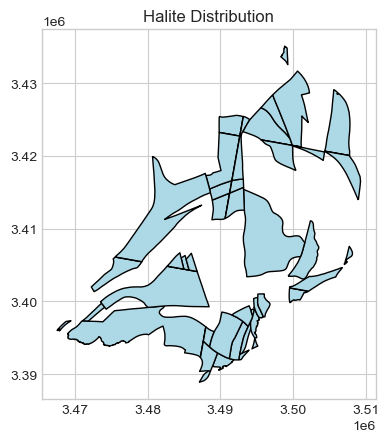

In [387]:
halite_gdf = gpd.GeoDataFrame(geometry=halite_shapes, crs="EPSG:3035")

halite_gdf.plot(edgecolor='black', facecolor='lightblue')
plt.title("Halite Distribution")
plt.show()

In [389]:
##### Step 7: Check spatial intersection between points and halite polygons

def point_in_halite(pt):
    return any(poly.intersects(pt) for poly in halite_shapes)

egms_gdf2['halite_presence'] = egms_gdf2.geometry.apply(point_in_halite).astype(int)

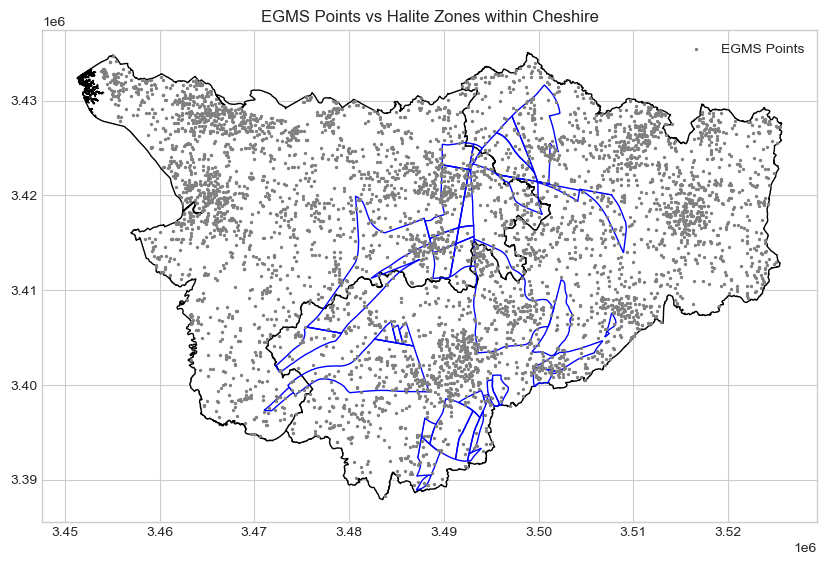

In [395]:
##### Step 8: Visual check 

import matplotlib.pyplot as plt
from shapely.geometry import Point
import geopandas as gpd

cheshire_union = cheshire.unary_union

halite_within_cheshire = halite_gdf[halite_gdf.geometry.within(cheshire_union)]

sample_points = egms_gdf2.sample(5000, random_state=42)   #Total no of point: 106338
sample_points_within_cheshire = sample_points[sample_points.geometry.within(cheshire_union)]

fig, ax = plt.subplots(figsize=(10, 10))

cheshire.plot(ax=ax, color='white', edgecolor='black')
halite_within_cheshire.plot(ax=ax, color='none', edgecolor='blue', linewidth=1, label='Halite Zones')
sample_points_within_cheshire.plot(ax=ax, color='grey', markersize=2, label='EGMS Points')

ax.set_aspect('equal')
plt.legend()
plt.title("EGMS Points vs Halite Zones within Cheshire")
plt.show()


In [399]:
##### Step 9: Move halite_presence to the first column
egms_gdf2.drop(columns='geometry', inplace=True)
cols = ['halite_presence'] + [col for col in egms_gdf2.columns if col != 'halite_presence']
egms_gdf2 = egms_gdf2[cols]

egms_gdf2.head(1)

halite_presence         pid  easting  northing  height  mean_velocity  \
72347                0  40fRTzd0L4  3464250   3398150    36.8           -1.3   

       acceleration  rmse  seasonality  20190113  ...  20231025  20231031  \
72347         -0.04   0.9          0.6      -0.6  ...      -7.1      -9.2   

       20231106  20231112  20231118  20231124  20231130  20231206  20231212  \
72347      -9.4      -8.6      -8.4      -8.4      -8.7      -9.0      -8.3   

       20231218  
72347      -7.4  

[1 rows x 310 columns]

## Time lag and time-series analysis

## 2) Feature engineering

In [618]:
egms_gdf2.sample(1)

halite_presence         pid  easting  northing  height  \
1421338                0  40flyTuQ6w  3479050   3425250    87.6   

         mean_velocity  acceleration  rmse  seasonality  20190113  ...  \
1421338            0.6         -0.22   3.0          1.3      -0.8  ...   

         20231025  20231031  20231106  20231112  20231118  20231124  20231130  \
1421338       3.1       9.5       7.8       5.3       3.8       1.7      -1.3   

         20231206  20231212  20231218  
1421338      -4.3      -3.2       0.9  

[1 rows x 310 columns]

In [805]:
egms_gdf2

halite_presence         pid  easting  northing  height  \
72347                  0  40fRTzd0L4  3464250   3398150    36.8   
72452                  0  40fQZje40J  3464350   3396950    21.9   
72454                  0  40fR1rdXAh  3464350   3397550    31.8   
72455                  0  40fRBEy1Yp  3464350   3397750    33.9   
72456                  0  40fRFvdGkt  3464350   3397850    37.3   
...                  ...         ...      ...       ...     ...   
1990950                0  40fSABcDBE  3498850   3399050    95.3   
1990951                0  40fSEsHSNI  3498850   3399150    96.2   
1990952                0  40fSJYwhZM  3498850   3399250    97.6   
1990953                0  40fSqNbPvo  3498850   3399950    83.6   
1991472                0  40fSlgwAjm  3499050   3399850    87.7   

         mean_velocity  acceleration  rmse  seasonality  20190113  ...  \
72347             -1.3         -0.04   0.9          0.6      -0.6  ...   
72452             -0.9         -0.13   1.3          0.6       1.1  ...   
72454             -1.4         -0.10   0.9          0.7      -0.7  ...   
72455             -1.4         -0.45   0.7          1.0      -0.5  ...   
72456             -1.5          0.08   0.8          0.1       0.9  ...   
...                ...           ...   ...          ...       ...  ...   
1990950            0.1          0.08   1.2          0.7       0.8  ...   
1990951            0.6          0.11   1.3          0.6       1.7  ...   
1990952            1.9          0.05   3.9          2.6      -6.6  ...   
1990953            0.7          0.41   1.6          1.1       0.6  ...   
1991472           -0.0          0.19   0.9          0.2      -0.0  ...   

         20231025  20231031  20231106  20231112  20231118  20231124  20231130  \
72347        -7.1      -9.2      -9.4      -8.6      -8.4      -8.4      -8.7   
72452        -3.6      -4.1      -4.5      -4.9      -5.0      -4.6      -3.7   
72454        -6.1      -6.5      -6.7      -7.2      -7.3      -7.0      -6.6   
72455        -7.3      -6.6      -6.3      -6.4      -7.1      -8.0      -7.2   
72456        -7.3      -7.6      -7.3      -6.9      -7.1      -7.4      -7.4   
...           ...       ...       ...       ...       ...       ...       ...   
1990950       1.5       2.9       3.5       3.7       3.3       3.1       1.9   
1990951       2.9       5.2       5.2       3.8       3.4       4.1       4.9   
1990952      11.8      11.3      11.6      13.2      15.2      16.7      15.8   
1990953       5.1       3.7       3.7       4.3       4.1       4.1       5.6   
1991472       0.8       1.4       1.7       1.5       0.7      -0.0      -0.0   

         20231206  20231212  20231218  
72347        -9.0      -8.3      -7.4  
72452        -3.1      -3.0      -3.0  
72454        -6.2      -6.2      -6.1  
72455        -5.9      -6.0      -6.6  
72456        -7.7      -7.7      -7.5  
...           ...       ...       ...  
1990950      -0.4      -0.0       1.8  
1990951       4.8       3.5       1.6  
1990952      13.6      10.2       5.0  
1990953       6.7       5.3       4.0  
1991472       0.0       0.1      -0.1  

[106338 rows x 310 columns]

In [823]:
pred_df.iloc[:,0]

0        -10.677790
1         -5.663609
2         -8.719972
3         -9.026409
4         -9.408139
            ...    
106333     1.106267
106334     3.446973
106335     9.465729
106336     4.212732
106337     0.273570
Name: 20231224, Length: 106338, dtype: float32

In [821]:
result_df_2 = pd.concat([egms_gdf2, pred_final], axis=1)
result_df_2[result_df_2['halite_presence'] == 1]

halite_presence         pid    easting   northing  height  \
78015                1.0  40fQLfeKQj  3468150.0  3396650.0    84.4   
78157                1.0  40fQLfeKQk  3468250.0  3396650.0    79.2   
78158                1.0  40fQQMJZco  3468250.0  3396750.0    77.6   
79834                1.0  40fOzHfuvn  3469550.0  3394850.0    67.7   
79959                1.0  40fOzHfuvo  3469650.0  3394850.0    55.9   
...                  ...         ...        ...        ...     ...   
1985677              1.0  40fSXcwR99  3496350.0  3399550.0    62.3   
1986019              1.0  40fSEsHSMv  3496550.0  3399150.0    85.1   
1986020              1.0  40fSJYwhYz  3496550.0  3399250.0    85.9   
1986021              1.0  40fSqNbPvR  3496550.0  3399950.0    72.6   
1986205              1.0  40fSlgwAjO  3496650.0  3399850.0    68.9   

         mean_velocity  acceleration  rmse  seasonality  20190113  ...  \
78015             -0.8         -0.16   0.6          0.5      -0.2  ...   
78157             -1.4          0.87   2.0          0.7      -0.1  ...   
78158             -1.9          0.09   1.9          0.6      -0.9  ...   
79834             -0.6         -0.02   1.7          0.8      -0.8  ...   
79959             -1.5         -0.09   1.4          0.1      -2.2  ...   
...                ...           ...   ...          ...       ...  ...   
1985677           -0.1         -0.36   2.5          1.4       0.2  ...   
1986019           -0.6          0.36   1.2          0.8      -0.1  ...   
1986020           -0.6          0.92   2.6          2.8      -2.9  ...   
1986021           -0.7          0.16   1.2          0.7      -1.5  ...   
1986205            0.5         -1.11   3.1          3.0       5.5  ...   

         20231031  20231106  20231112  20231118  20231124  20231130  20231206  \
78015        -2.8      -2.8      -3.2      -3.8      -4.2      -3.9      -3.1   
78157        -7.2      -8.5     -10.4     -11.5     -12.6     -10.7      -8.5   
78158        -8.9     -10.1     -11.3     -10.1      -8.3      -8.0      -8.5   
79834        -4.1      -5.2      -7.9      -6.8      -4.0      -3.1      -3.6   
79959        -7.7      -8.1      -8.2      -8.9     -10.7     -11.0     -10.1   
...           ...       ...       ...       ...       ...       ...       ...   
1985677       1.2      -1.1      -2.1      -1.0      -0.5      -0.4      -0.4   
1986019      -3.1      -2.5      -1.1      -1.1      -2.3      -2.8      -2.7   
1986020       0.9       0.3      -0.3      -0.9      -1.4      -2.5      -3.6   
1986021      -6.8      -7.1      -6.9      -6.6      -6.4      -6.5      -5.8   
1986205      -3.8      -1.8       0.3       0.9       1.0       2.5       4.2   

         20231212  20231218  20231224  
78015        -2.7      -2.9  2.283929  
78157        -8.8      -9.4 -5.329992  
78158       -10.0     -11.3 -1.512125  
79834        -3.6      -3.4  1.013129  
79959        -9.5      -9.3 -1.389719  
...           ...       ...       ...  
1985677      -2.0      -3.7       NaN  
1986019      -2.6      -1.8       NaN  
1986020      -3.1      -2.5       NaN  
1986021      -4.9      -4.7       NaN  
1986205       2.2      -2.6       NaN  

[22902 rows x 311 columns]

In [620]:
df= egms_gdf2.copy()
df.head(1)   # df has the seasonality data

halite_presence         pid  easting  northing  height  mean_velocity  \
72347                0  40fRTzd0L4  3464250   3398150    36.8           -1.3   

       acceleration  rmse  seasonality  20190113  ...  20231025  20231031  \
72347         -0.04   0.9          0.6      -0.6  ...      -7.1      -9.2   

       20231106  20231112  20231118  20231124  20231130  20231206  20231212  \
72347      -9.4      -8.6      -8.4      -8.4      -8.7      -9.0      -8.3   

       20231218  
72347      -7.4  

[1 rows x 310 columns]

In [621]:
##### Step 1: Construct lag features (retain original features)

# Step 1: Extract and build monthly lag features
target_date = '20231218'
days_per_observation = 6   # As our dataset has 6 days of term
days_per_month = 30
steps_per_month = days_per_month // days_per_observation 
num_months = 60  # 5 yrs

# 1. date col
date_cols = sorted([col for col in df.columns if col.isdigit()])

# 2. target_date
if target_date not in date_cols:
    raise ValueError(f"{target_date} not found in time columns. Please check column names.")

# 3. target_date : lag
target_idx = date_cols.index(target_date)
lag_cols = []
for i in range(1, num_months + 1):
    lag_idx = target_idx - i * steps_per_month
    if lag_idx >= 0:
        lag_date = date_cols[lag_idx]
        lag_name = f'lag_{i * steps_per_month}'
        df[lag_name] = df[lag_date]
        lag_cols.append(lag_name)
    else:
        break

# 4. stat col
static_cols = ['easting', 'northing', 'height', 'halite_presence', 'mean_velocity', 'acceleration', 'rmse', 'seasonality']

df = df[['pid'] + static_cols + lag_cols + [target_date]].dropna()
df = df.rename(columns={target_date: 'target'})

In [624]:
df.head(1)   # lag 5, 10, ..., 300 added

pid  easting  northing  height  halite_presence  mean_velocity  \
72347  40fRTzd0L4  3464250   3398150    36.8                0           -1.3   

       acceleration  rmse  seasonality  lag_5  ...  lag_260  lag_265  lag_270  \
72347         -0.04   0.9          0.6   -8.4  ...     -3.3     -4.1     -3.0   

       lag_275  lag_280  lag_285  lag_290  lag_295  lag_300  target  
72347     -2.7     -1.0     -2.2     -0.9      0.1     -0.6    -7.4  

[1 rows x 70 columns]

In [737]:
df['target'].describe()

count    106338.000000
mean         -2.932018
std           4.956985
min         -74.900000
25%          -5.400000
50%          -3.000000
75%          -0.200000
max          55.100000
Name: target, dtype: float64

In [626]:
##### Step 2 Construct rolling statistical features 

rolling_months = [3, 6, 12, 24, 36, 48, 60]  # 3m, 6m, 12m (short) / 24m, 36m, 48m, 60m (long)

for months in rolling_months:
    lag_steps = [f'lag_{i * 5}' for i in range(1, months + 1)]  # 1m ≒ 5 * 6days
    existing_cols = [col for col in lag_steps if col in df.columns]
    
    if len(existing_cols) < months:
        print(f"{months} : shortage {len(existing_cols)}")
    
    df[f'rolling_mean_{months}m'] = df[existing_cols].mean(axis=1)
    df[f'rolling_std_{months}m'] = df[existing_cols].std(axis=1)
    df[f'rolling_max_{months}m'] = df[existing_cols].max(axis=1)
    df[f'rolling_min_{months}m'] = df[existing_cols].min(axis=1)

In [628]:
df.head(1)  # rolling_mean, std, max, min of rolling_months(3, 6, 12, 24, 36, 48, 60): added

pid  easting  northing  height  halite_presence  mean_velocity  \
72347  40fRTzd0L4  3464250   3398150    36.8                0           -1.3   

       acceleration  rmse  seasonality  lag_5  ...  rolling_max_36m  \
72347         -0.04   0.9          0.6   -8.4  ...             -3.6   

       rolling_min_36m  rolling_mean_48m  rolling_std_48m  rolling_max_48m  \
72347             -9.3         -5.616667         1.723842             -1.8   

       rolling_min_48m  rolling_mean_60m  rolling_std_60m  rolling_max_60m  \
72347             -9.3         -4.896667         2.185698              0.1   

       rolling_min_60m  
72347             -9.3  

[1 rows x 98 columns]

In [630]:
##### Step 3: Construct interaction features

interaction_static = ['mean_velocity', 'acceleration']

for col in interaction_static:
    df[f'halite_x_{col}'] = df['halite_presence'] * df[col]

# for col in lag_cols:
#     df[f'halite_x_{col}'] = df['halite_presence'] * df[col]

# for months in rolling_months:
#     col_name = f'rolling_mean_{months}m'
#     if col_name in df.columns:
#         df[f'halite_x_{col_name}'] = df['halite_presence'] * df[col_name]

df1 = df.copy()
df.head(1)

pid  easting  northing  height  halite_presence  mean_velocity  \
72347  40fRTzd0L4  3464250   3398150    36.8                0           -1.3   

       acceleration  rmse  seasonality  lag_5  ...  rolling_mean_48m  \
72347         -0.04   0.9          0.6   -8.4  ...         -5.616667   

       rolling_std_48m  rolling_max_48m  rolling_min_48m  rolling_mean_60m  \
72347         1.723842             -1.8             -9.3         -4.896667   

       rolling_std_60m  rolling_max_60m  rolling_min_60m  \
72347         2.185698              0.1             -9.3   

       halite_x_mean_velocity  halite_x_acceleration  
72347                    -0.0                   -0.0  

[1 rows x 100 columns]

**NOTE** : Since halite_presence is a simple binary variable (0 or 1), multiplying the time series variables (lag, rolling month) by halite is just scaling the time series itself and doesn't add any new information. The lag and rolling values already inherently contain sequential changes reflecting time information. Adding a multiplicative interaction with halite would likely only increase complexity without significantly improving prediction performance. Therefore, it would be better to only multiply with the interaction_static = ['mean_velocity', 'acceleration'] features.

In [632]:
##### Step 4: Combining features
static_cols = ['height', 'mean_velocity', 'acceleration', 'rmse', 'seasonality']
rolling_features = [col for col in df.columns if col.startswith('rolling_')]
interaction_features = [col for col in df.columns if col.startswith('halite_x_')]

feature_cols = ['halite_presence'] + interaction_features + static_cols + lag_cols + rolling_features 

X = df[feature_cols]
y = df['target']

df = pd.concat([df[['pid']], X, y], axis=1)
df.head(1)

pid  halite_presence  halite_x_mean_velocity  \
72347  40fRTzd0L4                0                    -0.0   

       halite_x_acceleration  height  mean_velocity  acceleration  rmse  \
72347                   -0.0    36.8           -1.3         -0.04   0.9   

       seasonality  lag_5  ...  rolling_min_36m  rolling_mean_48m  \
72347          0.6   -8.4  ...             -9.3         -5.616667   

       rolling_std_48m  rolling_max_48m  rolling_min_48m  rolling_mean_60m  \
72347         1.723842             -1.8             -9.3         -4.896667   

       rolling_std_60m  rolling_max_60m  rolling_min_60m  target  
72347         2.185698              0.1             -9.3    -7.4  

[1 rows x 98 columns]

In [634]:
##### Step 5: Standardize selected static features

from sklearn.preprocessing import StandardScaler

cols_to_scale = ['height', 'mean_velocity', 'acceleration', 'rmse', 'seasonality']
scaler = StandardScaler()

for col in cols_to_scale:
    df[f'{col}_scaled'] = scaler.fit_transform(df[[col]])

In [636]:
df.head(1)

pid  halite_presence  halite_x_mean_velocity  \
72347  40fRTzd0L4                0                    -0.0   

       halite_x_acceleration  height  mean_velocity  acceleration  rmse  \
72347                   -0.0    36.8           -1.3         -0.04   0.9   

       seasonality  lag_5  ...  rolling_mean_60m  rolling_std_60m  \
72347          0.6   -8.4  ...         -4.896667         2.185698   

       rolling_max_60m  rolling_min_60m  target  height_scaled  \
72347              0.1             -9.3    -7.4      -0.552393   

       mean_velocity_scaled  acceleration_scaled  rmse_scaled  \
72347              -0.77579            -0.088086    -0.540831   

       seasonality_scaled  
72347           -0.044281  

[1 rows x 103 columns]

In [638]:
##### Step 6: Add Enhanced Features

### 1. Acceleration-like differences \
# for i in range(len(monthly_lag_cols) - 1):
#     col1 = monthly_lag_cols[i]
#     col2 = monthly_lag_cols[i + 1]
#     df[f'lag_diff_{i+1}_{i+2}m'] = df[col1] - df[col2]

### 2. Cumulative displacement 
# df['cumulative_displacement'] = df[monthly_lag_cols].sum(axis=1)

### 3. Extreme values
# df['lag_max'] = df[monthly_lag_cols].max(axis=1)
# df['lag_min'] = df[monthly_lag_cols].min(axis=1)

### 4. Ratio feature
ratio_pairs = [
    (3, 6),
    (6, 12),
    (12, 24),
    (24, 60),
    (3, 60),
]

for short, long in ratio_pairs:
    short_col = f'rolling_mean_{short}m'
    long_col = f'rolling_mean_{long}m'
    if short_col in df.columns and long_col in df.columns:
        df[f'ratio_{short}m_vs_{long}m'] = df[short_col] / (df[long_col] + 1e-5)


### 5. Continuous decline count
# df['continuous_decline_count'] = (df[monthly_ldfag_cols].diff(axis=1) < 0).sum(axis=1)

### 6. Spatial interaction 
# df['halite_x_cumulative_displacement'] = df['halite_presence'] * df['cumulative_displacement']

df2 = df.copy()
df.head(1)

pid  halite_presence  halite_x_mean_velocity  \
72347  40fRTzd0L4                0                    -0.0   

       halite_x_acceleration  height  mean_velocity  acceleration  rmse  \
72347                   -0.0    36.8           -1.3         -0.04   0.9   

       seasonality  lag_5  ...  height_scaled  mean_velocity_scaled  \
72347          0.6   -8.4  ...      -0.552393              -0.77579   

       acceleration_scaled  rmse_scaled  seasonality_scaled  ratio_3m_vs_6m  \
72347            -0.088086    -0.540831           -0.044281        1.002107   

       ratio_6m_vs_12m  ratio_12m_vs_24m  ratio_24m_vs_60m  ratio_3m_vs_60m  
72347         1.063831          1.112774          1.365728         1.620153  

[1 rows x 108 columns]

**NOTE** There are too many lags. I think it would be better to only run it for 4 lags instead of comparing with every previous point.
Regarding cumulative displacement, ground subsidence isn't always just a cumulative phenomenon. There can be repeated uplift and sinking. Therefore, the total sum might lead to a distorted interpretation compared to the average. I don't think it's necessary to add it.
Similarly, for extreme values, since we're using data from EGMS that has already had a regression model applied, I don't think we need to identify them separately. The same logic applies to the rest.
Therefore, I will only add feature number 4.

In [568]:
print(f"halite present: {len(df[df['halite_presence'] != 0])}")
print(f"halite not present: {len(df[df['halite_presence'] == 0])}")

halite present: 22902
halite not present: 83436


**NOTE** In this part, 4. Ratio feature has been enlarged and added using diversity of the lags


## 3) Correaltion heatmap

In [580]:
df.head(1)

pid  halite_presence  halite_x_mean_velocity  \
72347  40fRTzd0L4                0                    -0.0   

       halite_x_acceleration  height  mean_velocity  acceleration  rmse  \
72347                   -0.0    36.8           -1.3         -0.04   0.9   

       seasonality  lag_5  ...  height_scaled  mean_velocity_scaled  \
72347          0.6   -8.4  ...      -0.552393              -0.77579   

       acceleration_scaled  rmse_scaled  seasonality_scaled  ratio_3m_vs_6m  \
72347            -0.088086    -0.540831           -0.044281        1.002107   

       ratio_6m_vs_12m  ratio_12m_vs_24m  ratio_24m_vs_60m  ratio_3m_vs_60m  
72347         1.063831          1.112774          1.365728         1.620153  

[1 rows x 108 columns]

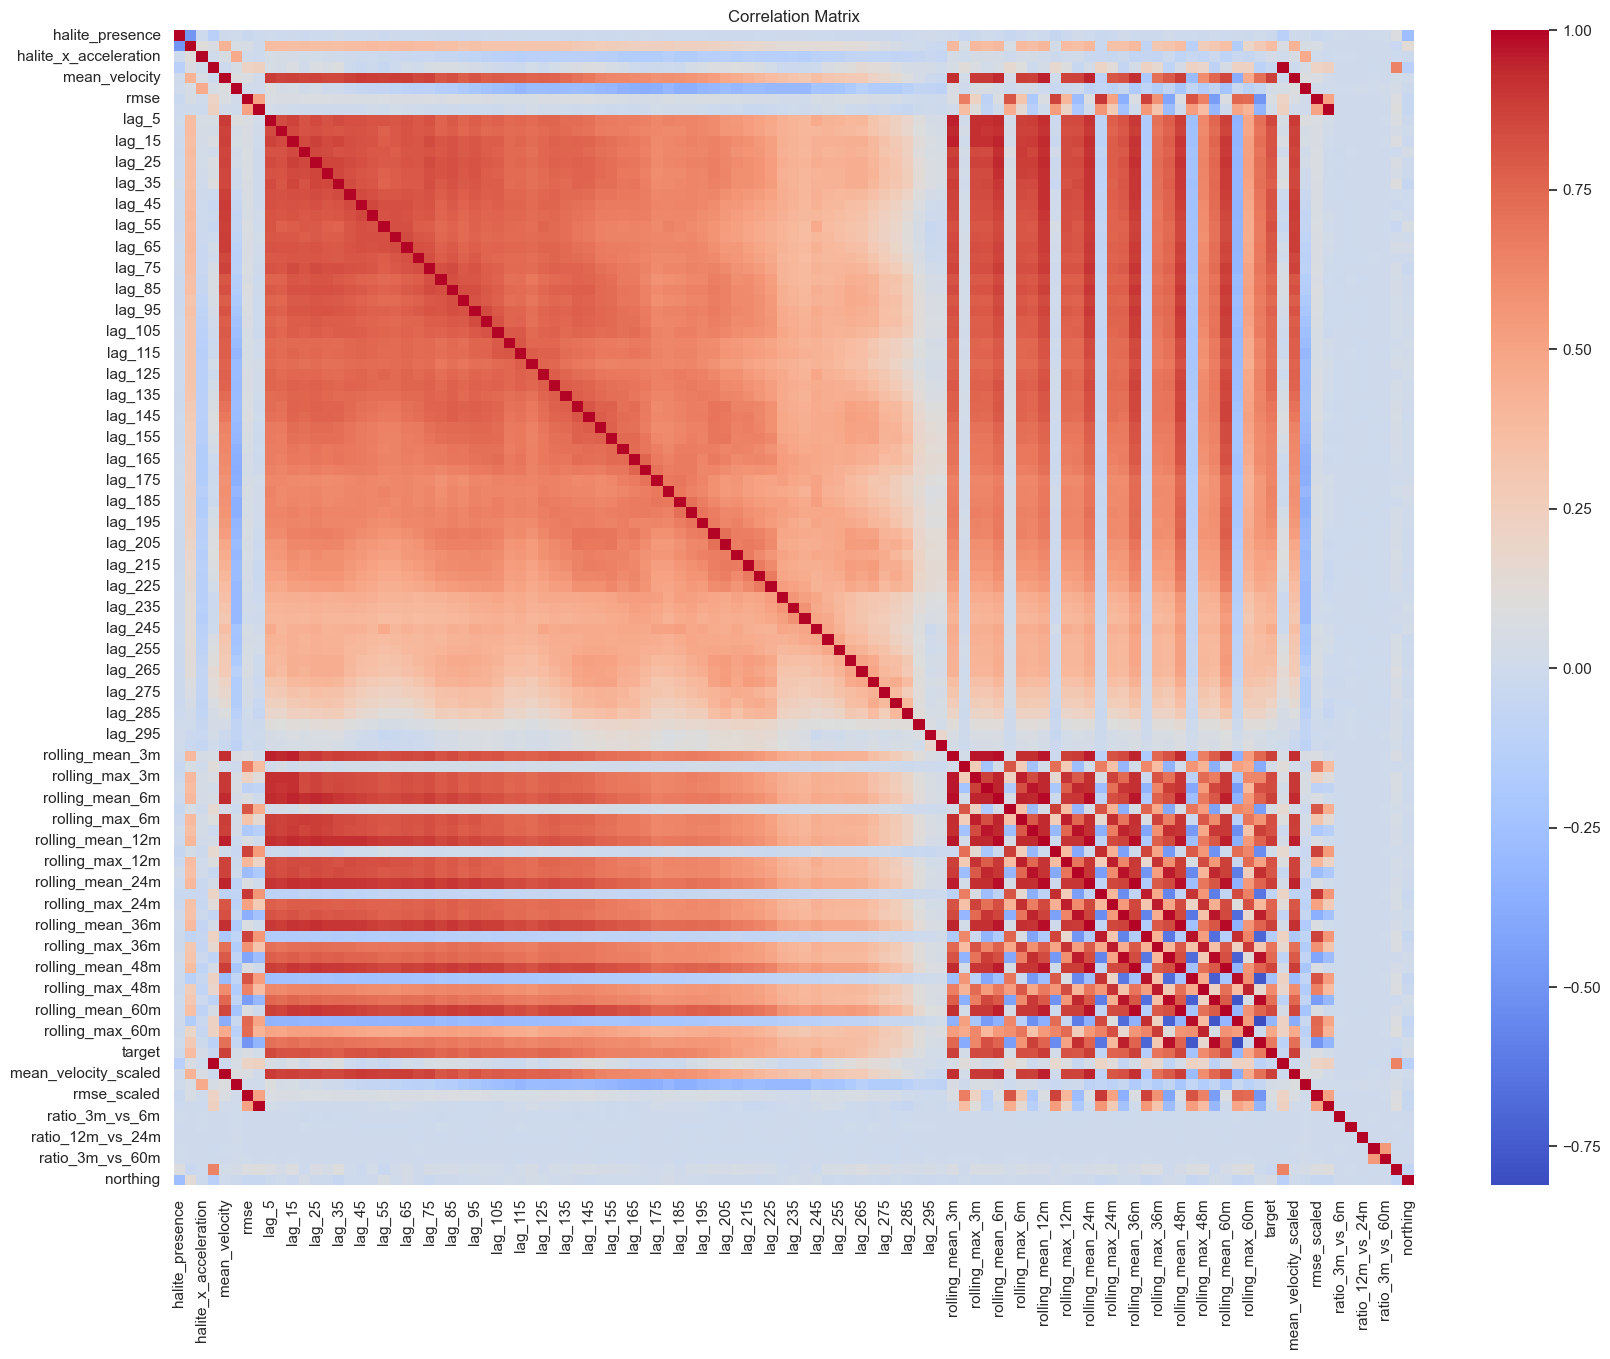

In [843]:
corr_matrix = df.drop(columns=['pid']).corr()

plt.figure(figsize=(20, 15))
sns.heatmap(corr_matrix, cmap='coolwarm', annot=False, fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

## 4) ML model selection

In [660]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split, KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
import numpy as np

X = df.drop(columns=['pid', 'target', 'height', 'mean_velocity', 'acceleration', 'rmse', 'seasonality'])
y = df['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# KFold
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

### (1) XGboost

In [662]:
xgb_model = xgb.XGBRegressor(random_state=42)

xgb_params = {
    'n_estimators': [100, 200],
    'max_depth': [3, 6],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

xgb_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=xgb_params,
    scoring='neg_root_mean_squared_error',
    cv=kfold,
    verbose=1,
    n_jobs=-1
)

xgb_search.fit(X_train, y_train)

best_xgb = xgb_search.best_estimator_

y_pred_xgb = best_xgb.predict(X_test)

print("Best XGBoost Results:")
print(f"RMSE: {mean_squared_error(y_test, y_pred_xgb, squared=False):.3f}")
print(f"MAE: {mean_absolute_error(y_test, y_pred_xgb):.3f}")
print(f"R²: {r2_score(y_test, y_pred_xgb):.3f}")

Fitting 5 folds for each of 32 candidates, totalling 160 fits
Best XGBoost Results:
RMSE: 1.994
MAE: 1.311
R²: 0.840


### (2) RandomForest

In [663]:
rf_model = RandomForestRegressor(random_state=42)

rf_params = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'max_features': ['sqrt', 'log2'],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

rf_search = GridSearchCV(
    estimator=rf_model,
    param_grid=rf_params,
    scoring='neg_root_mean_squared_error',
    cv=kfold,
    verbose=1,
    n_jobs=-1
)

rf_search.fit(X_train, y_train)

best_rf = rf_search.best_estimator_
y_pred_rf = best_rf.predict(X_test)

print("Best RandomForest Results:")
print(f"RMSE: {mean_squared_error(y_test, y_pred_rf, squared=False):.3f}")
print(f"MAE: {mean_absolute_error(y_test, y_pred_rf):.3f}")
print(f"R²: {r2_score(y_test, y_pred_rf):.3f}")

Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best RandomForest Results:
RMSE: 2.082
MAE: 1.374
R²: 0.825


### (3) Comparison

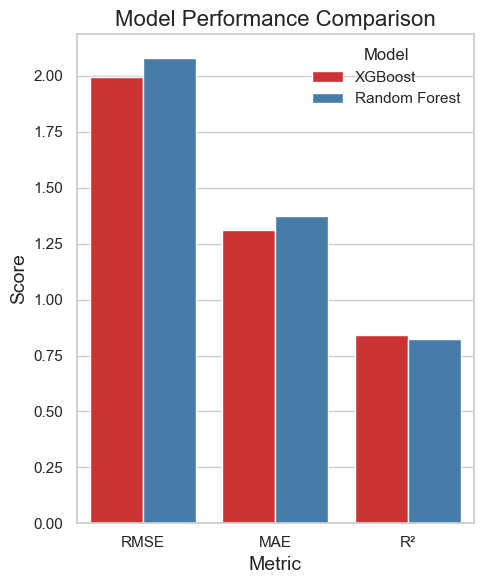

In [666]:
data = {
    'Model': ['XGBoost', 'XGBoost', 'XGBoost', 'Random Forest', 'Random Forest', 'Random Forest'],
    'Metric': ['RMSE', 'MAE', 'R²', 'RMSE', 'MAE', 'R²'],
    'Score': [1.994, 1.311, 0.840, 2.082, 1.374, 0.825]}

df_ = pd.DataFrame(data)

plt.figure(figsize=(5, 6))
bar_plot = sns.barplot(x='Metric', y='Score', hue='Model', data=df_, palette='Set1')

plt.title('Model Performance Comparison', fontsize=16)
plt.xlabel('Metric', fontsize=14)
plt.ylabel('Score', fontsize=14)

plt.tight_layout()

plt.show()

In [668]:
print("Best XGBoost Parameters:", xgb_search.best_params_)

Best XGBoost Parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 200, 'subsample': 1.0}


In [845]:
print("Best RFR Parameters:", rf_search.best_params_)

Best RFR Parameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}


## 5) ML model prediction

In [1112]:
df_merged = pd.concat([df2, df1[['easting', 'northing']]], axis=1)
df_merged

pid  halite_presence  halite_x_mean_velocity  \
72347    40fRTzd0L4                0                    -0.0   
72452    40fQZje40J                0                    -0.0   
72454    40fR1rdXAh                0                    -0.0   
72455    40fRBEy1Yp                0                    -0.0   
72456    40fRFvdGkt                0                    -0.0   
...             ...              ...                     ...   
1990950  40fSABcDBE                0                     0.0   
1990951  40fSEsHSNI                0                     0.0   
1990952  40fSJYwhZM                0                     0.0   
1990953  40fSqNbPvo                0                     0.0   
1991472  40fSlgwAjm                0                    -0.0   

         halite_x_acceleration  height  mean_velocity  acceleration  rmse  \
72347                     -0.0    36.8           -1.3         -0.04   0.9   
72452                     -0.0    21.9           -0.9         -0.13   1.3   
72454                     -0.0    31.8           -1.4         -0.10   0.9   
72455                     -0.0    33.9           -1.4         -0.45   0.7   
72456                      0.0    37.3           -1.5          0.08   0.8   
...                        ...     ...            ...           ...   ...   
1990950                    0.0    95.3            0.1          0.08   1.2   
1990951                    0.0    96.2            0.6          0.11   1.3   
1990952                    0.0    97.6            1.9          0.05   3.9   
1990953                    0.0    83.6            0.7          0.41   1.6   
1991472                    0.0    87.7           -0.0          0.19   0.9   

         seasonality  lag_5  ...  acceleration_scaled  rmse_scaled  \
72347            0.6   -8.4  ...            -0.088086    -0.540831   
72452            0.6   -5.0  ...            -0.310665    -0.079366   
72454            0.7   -7.3  ...            -0.236472    -0.540831   
72455            1.0   -7.1  ...            -1.102057    -0.771563   
72456            0.1   -7.1  ...             0.208687    -0.656197   
...              ...    ...  ...                  ...          ...   
1990950          0.7    3.3  ...             0.208687    -0.194732   
1990951          0.6    3.4  ...             0.282880    -0.079366   
1990952          2.6   15.2  ...             0.134493     2.920156   
1990953          1.1    4.1  ...             1.024810     0.266733   
1991472          0.2    0.7  ...             0.480728    -0.540831   

         seasonality_scaled  ratio_3m_vs_6m  ratio_6m_vs_12m  \
72347             -0.044281        1.002107         1.063831   
72452             -0.044281        0.977101         0.947561   
72454              0.155168        1.055002         1.030929   
72455              0.753515        0.981212         1.184180   
72456             -1.041527        1.081341         1.055557   
...                     ...             ...              ...   
1990950            0.155168        1.045866         0.912129   
1990951           -0.044281        0.958900         1.073525   
1990952            3.944700        1.322665         0.900359   
1990953            0.952964        1.623181         0.932429   
1991472           -0.842078        0.646148         2.166623   

         ratio_12m_vs_24m  ratio_24m_vs_60m  ratio_3m_vs_60m  easting  \
72347            1.112774          1.365728         1.620153  3464250   
72452            1.274197          1.565663         1.847050  3464350   
72454            1.150484          1.548443         1.937563  3464350   
72455            1.200299          1.594893         2.224332  3464350   
72456            1.107694          1.564556         1.978123  3464350   
...                   ...               ...              ...      ...   
1990950          1.448474          1.028671         1.421436  3498850   
1990951          0.896207          1.846094         1.703151  3498850   
1990952          1.203755          2.202410         3.1

In [1113]:
df = df_merged.copy()
X = df.drop(columns=['pid', 'easting', 'northing', 'target', 'height', 'mean_velocity', 'acceleration', 'rmse', 'seasonality'])
y = df['target']
coords = df[['easting', 'northing']].copy()
halite_mask = df['halite_presence'] == 1 

# Best model and params
model_xgb = xgb.XGBRegressor(
    colsample_bytree= 0.8,
    n_estimators=200,
    learning_rate=0.1,
    max_depth=6,
    subsample= 1.0,
    random_state=42
)

model_xgb.fit(X, y)

X_current = X.copy()

In [1115]:
y_preds_all_years = []
X_current = X.copy()

# target steps (6 days observ * 5 lag(setting) * 12 = 1yr(approx 360 days))
target_steps = [61, 121, 181, 241, 301]
step_counter = 0

for step in range(1, target_steps[-1] + 1):
    y_pred_step = model_xgb.predict(X_current)
    step_counter += 1

    if step in target_steps:
        y_preds_all_years.append(y_pred_step.copy())

    if step % lag_step_size == 0:
        for i in range(max_lag, lag_step_size, -lag_step_size):
            cur, prev = f'lag_{i}', f'lag_{i - lag_step_size}'
            if cur in X_current.columns and prev in X_current.columns:
                X_current[cur] = X_current[prev]

        if f'lag_{lag_step_size}' in X_current.columns:
            X_current[f'lag_{lag_step_size}'] = y_pred_step

    for window in [3, 6, 12, 24, 60]:
        step_lags = window * 30 // days_per_step
        relevant_lags = [f'lag_{i}' for i in range(1, step_lags + 1)
                         if i % lag_step_size == 0 and f'lag_{i}' in X_current.columns]
        if relevant_lags:
            mean_col = f'rolling_mean_{window}m'
            std_col = f'rolling_std_{window}m'
            if mean_col in X_current.columns:
                X_current[mean_col] = X_current[relevant_lags].mean(axis=1)
            if std_col in X_current.columns:
                X_current[std_col] = X_current[relevant_lags].std(axis=1)

    for short, long in [(3, 6), (6, 12), (12, 24), (24, 60), (3, 60)]:
        short_col = f'rolling_mean_{short}m'
        long_col = f'rolling_mean_{long}m'
        ratio_col = f'ratio_{short}m_vs_{long}m'
        if short_col in X_current.columns and long_col in X_current.columns and ratio_col in X_current.columns:
            X_current[ratio_col] = X_current[short_col] / (X_current[long_col] + 1e-5)

# Result_df
years = [2024, 2025, 2026, 2027, 2028]
result_df = pd.DataFrame({
    'easting': df['easting'].values,
    'northing': df['northing'].values,
})

for i, year in enumerate(years):
    result_df[str(year)] = y_preds_all_years[i]

result_df.head()

easting  northing       2024       2025       2026       2027       2028
0  3464250   3398150 -10.677790 -12.575670 -16.186544 -18.866556 -21.557535
1  3464350   3396950  -5.663609  -7.394112  -9.822605 -12.164733 -14.811028
2  3464350   3397550  -8.719972 -12.221581 -14.304512 -17.641525 -21.388945
3  3464350   3397750  -9.026409 -12.052889 -15.453008 -17.766947 -22.987576
4  3464350   3397850  -9.408139 -11.988132 -14.445389 -17.268127 -18.967918

In [1116]:
result_df[['2024','2025','2026','2027','2028']].describe()

2024           2025           2026           2027  \
count  106338.000000  106338.000000  106338.000000  106338.000000   
mean       -3.883879      -4.765474      -5.850622      -7.087749   
std         5.301044       6.273518       7.289162       8.387749   
min       -68.386635     -67.959824     -67.514786     -67.468269   
25%        -6.551343      -8.332189     -10.477973     -12.596468   
50%        -3.960469      -4.715956      -5.716442      -7.090521   
75%        -0.890432      -0.982088      -1.197655      -1.455837   
max        51.830746      50.683704      49.627422      49.681854   

                2028  
count  106338.000000  
mean       -8.344489  
std         9.450662  
min       -67.753113  
25%       -15.567700  
50%        -8.586254  
75%        -1.641479  
max        49.606853

In [1118]:
a = df_merged[['pid', 'halite_presence', 'lag_300', 'lag_240', 'lag_180', 'lag_120', 'lag_60', 'target',
               'height_scaled','acceleration_scaled','rmse_scaled',	'seasonality_scaled',
               'easting', 'northing']]

In [1119]:
a.rename(columns={'lag_300': '2019(s)'}, inplace=True)
a.rename(columns={'lag_240': '2019'}, inplace=True)
a.rename(columns={'lag_180': '2020'}, inplace=True)
a.rename(columns={'lag_120': '2021'}, inplace=True)
a.rename(columns={'lag_60': '2022'}, inplace=True)
a.rename(columns={'target': '2023'}, inplace=True)
a.head(1)

pid  halite_presence  2019(s)  2019  2020  2021  2022  2023  \
72347  40fRTzd0L4                0     -0.6  -2.1  -5.7  -6.7  -5.0  -7.4   

       height_scaled  acceleration_scaled  rmse_scaled  seasonality_scaled  \
72347      -0.552393            -0.088086    -0.540831           -0.044281   

       easting  northing  
72347  3464250   3398150

In [1129]:
a

pid  halite_presence  2019(s)  2019  2020  2021  2022  2023  \
72347    40fRTzd0L4                0     -0.6  -2.1  -5.7  -6.7  -5.0  -7.4   
72452    40fQZje40J                0      1.1  -0.9  -1.2  -2.2  -4.7  -3.0   
72454    40fR1rdXAh                0     -0.7  -1.2  -4.6  -2.9  -5.7  -6.1   
72455    40fRBEy1Yp                0     -0.5  -1.0  -1.2  -1.1  -5.0  -6.6   
72456    40fRFvdGkt                0      0.9  -1.5  -4.8  -5.2  -5.7  -7.5   
...             ...              ...      ...   ...   ...   ...   ...   ...   
1990950  40fSABcDBE                0      0.8   1.3   1.0   1.3   2.5   1.8   
1990951  40fSEsHSNI                0      1.7  -0.6  -0.7   0.6   1.2   1.6   
1990952  40fSJYwhZM                0     -6.6  -1.2   0.0   5.9  14.1   5.0   
1990953  40fSqNbPvo                0      0.6   0.5   4.6   1.8   3.1   4.0   
1991472  40fSlgwAjm                0     -0.0   0.1  -0.3   1.2  -0.1  -0.1   

         height_scaled  acceleration_scaled  rmse_scaled  seasonality_scaled  \
72347        -0.552393            -0.088086    -0.540831           -0.044281   
72452        -0.780875            -0.310665    -0.079366           -0.044281   
72454        -0.629065            -0.236472    -0.540831            0.155168   
72455        -0.596863            -1.102057    -0.771563            0.753515   
72456        -0.544726             0.208687    -0.656197           -1.041527   
...                ...                  ...          ...                 ...   
1990950       0.344667             0.208687    -0.194732            0.155168   
1990951       0.358468             0.282880    -0.079366           -0.044281   
1990952       0.379936             0.134493     2.920156            3.944700   
1990953       0.165255             1.024810     0.266733            0.952964   
1991472       0.228126             0.480728    -0.540831           -0.842078   

         easting  northing  
72347    3464250   3398150  
72452    3464350   3396950  
72454    3464350   3397550  
72455    3464350   3397750  
72456    3464350   3397850  
...          ...       ...  
1990950  3498850   3399050  
1990951  3498850   3399150  
1990952  3498850   3399250  
1990953  3498850   3399950  
1991472  3499050   3399850  

[106338 rows x 14 columns]

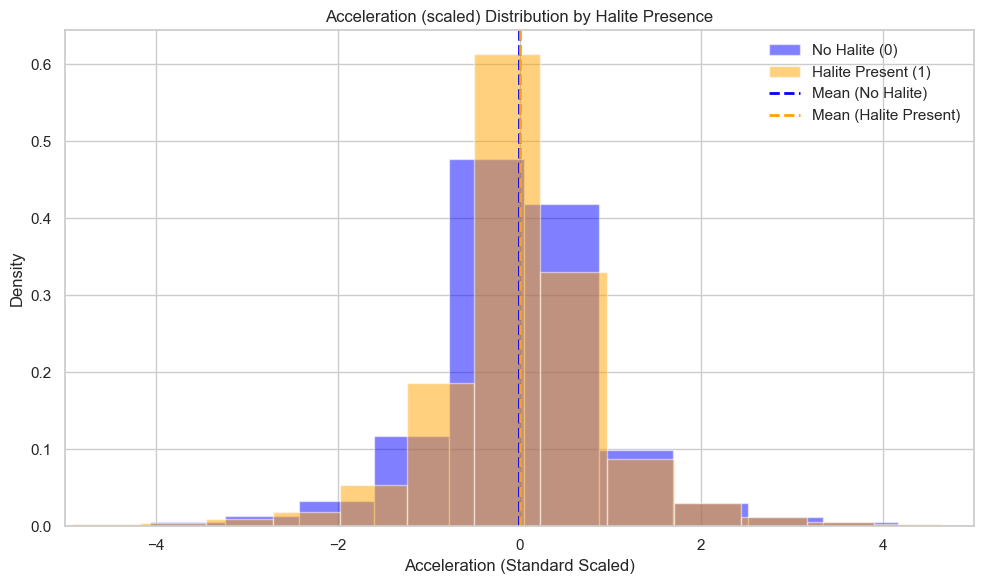

In [1200]:
# a = Trend data

plt.figure(figsize=(10, 6))

no_halite = a[a['halite_presence'] == 0]['acceleration_scaled']
halite = a[a['halite_presence'] == 1]['acceleration_scaled']

plt.hist(
    a[a['halite_presence'] == 0]['acceleration_scaled'],
    bins=30, alpha=0.5, label='No Halite (0)', density=True, color='blue'
)
plt.hist(
    a[a['halite_presence'] == 1]['acceleration_scaled'],
    bins=30, alpha=0.5, label='Halite Present (1)', density=True, color='orange'
)

plt.axvline(no_halite.mean(), color='blue', linestyle='dashed', linewidth=2, label='Mean (No Halite)')
plt.axvline(halite.mean(), color='orange', linestyle='dashed', linewidth=2, label='Mean (Halite Present)')

plt.title('Acceleration (scaled) Distribution by Halite Presence')
plt.xlabel('Acceleration (Standard Scaled)')
plt.xlim(-5, 5)
plt.ylabel('Density')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [1131]:
result_df

easting  northing       2024       2025       2026       2027  \
0       3464250   3398150 -10.677790 -12.575670 -16.186544 -18.866556   
1       3464350   3396950  -5.663609  -7.394112  -9.822605 -12.164733   
2       3464350   3397550  -8.719972 -12.221581 -14.304512 -17.641525   
3       3464350   3397750  -9.026409 -12.052889 -15.453008 -17.766947   
4       3464350   3397850  -9.408139 -11.988132 -14.445389 -17.268127   
...         ...       ...        ...        ...        ...        ...   
106333  3498850   3399050   1.106267   1.586105   1.717063   2.697244   
106334  3498850   3399150   3.446973   4.295907   6.359365   6.392908   
106335  3498850   3399250   9.465729  10.355929   9.645218  14.280478   
106336  3498850   3399950   4.212732   6.281293   7.149160   8.044113   
106337  3499050   3399850   0.273570   0.331102   0.528754   0.604216   

             2028  
0      -21.557535  
1      -14.811028  
2      -21.388945  
3      -22.987576  
4      -18.967918  
...           ...  
106333   2.263036  
106334   8.547093  
106335  15.682052  
106336  10.392862  
106337   0.529534  

[106338 rows x 7 columns]

In [1139]:
# Trend + Prediction
a = a.reset_index(drop=True)
combined_df = pd.concat([a, result_df[['2024', '2025', '2026', '2027', '2028']]], axis=1)
combined_df

pid  halite_presence  2019(s)  2019  2020  2021  2022  2023  \
0       40fRTzd0L4                0     -0.6  -2.1  -5.7  -6.7  -5.0  -7.4   
1       40fQZje40J                0      1.1  -0.9  -1.2  -2.2  -4.7  -3.0   
2       40fR1rdXAh                0     -0.7  -1.2  -4.6  -2.9  -5.7  -6.1   
3       40fRBEy1Yp                0     -0.5  -1.0  -1.2  -1.1  -5.0  -6.6   
4       40fRFvdGkt                0      0.9  -1.5  -4.8  -5.2  -5.7  -7.5   
...            ...              ...      ...   ...   ...   ...   ...   ...   
106333  40fSABcDBE                0      0.8   1.3   1.0   1.3   2.5   1.8   
106334  40fSEsHSNI                0      1.7  -0.6  -0.7   0.6   1.2   1.6   
106335  40fSJYwhZM                0     -6.6  -1.2   0.0   5.9  14.1   5.0   
106336  40fSqNbPvo                0      0.6   0.5   4.6   1.8   3.1   4.0   
106337  40fSlgwAjm                0     -0.0   0.1  -0.3   1.2  -0.1  -0.1   

        height_scaled  acceleration_scaled  rmse_scaled  seasonality_scaled  \
0           -0.552393            -0.088086    -0.540831           -0.044281   
1           -0.780875            -0.310665    -0.079366           -0.044281   
2           -0.629065            -0.236472    -0.540831            0.155168   
3           -0.596863            -1.102057    -0.771563            0.753515   
4           -0.544726             0.208687    -0.656197           -1.041527   
...               ...                  ...          ...                 ...   
106333       0.344667             0.208687    -0.194732            0.155168   
106334       0.358468             0.282880    -0.079366           -0.044281   
106335       0.379936             0.134493     2.920156            3.944700   
106336       0.165255             1.024810     0.266733            0.952964   
106337       0.228126             0.480728    -0.540831           -0.842078   

        easting  northing       2024       2025       2026       2027  \
0       3464250   3398150 -10.677790 -12.575670 -16.186544 -18.866556   
1       3464350   3396950  -5.663609  -7.394112  -9.822605 -12.164733   
2       3464350   3397550  -8.719972 -12.221581 -14.304512 -17.641525   
3       3464350   3397750  -9.026409 -12.052889 -15.453008 -17.766947   
4       3464350   3397850  -9.408139 -11.988132 -14.445389 -17.268127   
...         ...       ...        ...        ...        ...        ...   
106333  3498850   3399050   1.106267   1.586105   1.717063   2.697244   
106334  3498850   3399150   3.446973   4.295907   6.359365   6.392908   
106335  3498850   3399250   9.465729  10.355929   9.645218  14.280478   
106336  3498850   3399950   4.212732   6.281293   7.149160   8.044113   
106337  3499050   3399850   0.273570   0.331102   0.528754   0.604216   

             2028  
0      -21.557535  
1      -14.811028  
2      -21.388945  
3      -22.987576  
4      -18.967918  
...           ...  
106333   2.263036  
106334   8.547093  
106335  15.682052  
106336  10.392862  
106337   0.529534  

[106338 rows x 19 columns]

In [1215]:
combined_df.rename(columns = {'2019(s)':'2018'}, inplace = True)

years = ['2018','2019', '2020', '2021', '2022', '2023','2024', '2025', '2026', '2027', '2028']
stats_list = []

for year in years:
    for halite_val in [0, 1]:
        subset = combined_df[combined_df['halite_presence'] == halite_val]
        stats = {
            'year': year,
            'halite_presence': halite_val,
            'count': len(subset),
            'mean': subset[year].mean(),
            'min': subset[year].min(),
            'max': subset[year].max()
        }
        stats_list.append(stats)

summary_df = pd.DataFrame(stats_list)

summary_df = summary_df.sort_values(by=['year', 'halite_presence']).reset_index(drop=True)

summary_df

year  halite_presence  count      mean        min        max
0   2018                0  83436 -0.083072 -13.900000  16.500000
1   2018                1  22902 -0.069134 -18.100000  12.600000
2   2019                0  83436 -0.725366 -17.200000  22.600000
3   2019                1  22902 -0.730962 -15.300000  16.200000
4   2020                0  83436 -1.295660 -29.900000  25.100000
5   2020                1  22902 -1.328225 -31.300000  30.300000
6   2021                0  83436 -1.659365 -40.500000  40.800000
7   2021                1  22902 -1.726434 -45.700000  37.500000
8   2022                0  83436 -2.430221 -52.800000  45.000000
9   2022                1  22902 -2.447572 -62.400000  44.900000
10  2023                0  83436 -2.897978 -69.300000  53.900000
11  2023                1  22902 -3.056030 -74.900000  55.100000
12  2024                0  83436 -3.873831 -67.040833  51.830746
13  2024                1  22902 -3.920489 -68.386635  46.826153
14  2025                0  83436 -4.756872 -67.776207  50.683704
15  2025                1  22902 -4.796813 -67.959824  48.741024
16  2026                0  83436 -5.838278 -67.184105  49.627422
17  2026                1  22902 -5.895596 -67.514786  47.696075
18  2027                0  83436 -7.083111 -66.705147  49.681854
19  2027                1  22902 -7.104640 -67.468269  47.723900
20  2028                0  83436 -8.336534 -66.948509  49.606853
21  2028                1  22902 -8.373473 -67.753113  47.511894

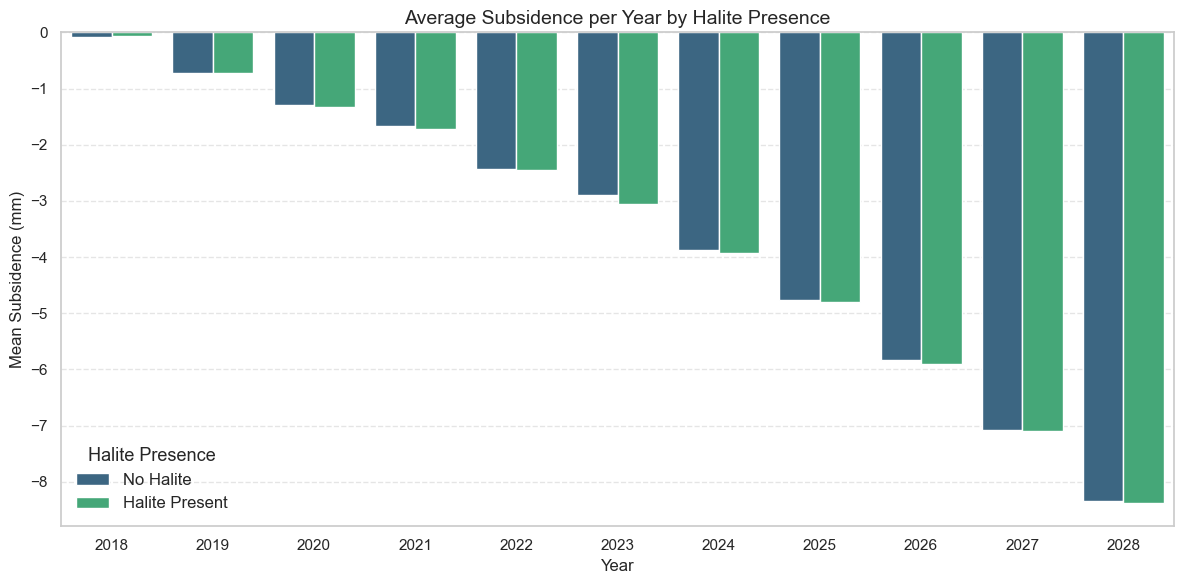

In [1235]:
plt.figure(figsize=(12, 6))
sns.barplot(
    data=summary_df,
    x='year',
    y='mean',
    hue='halite_presence',
    palette='viridis')

handles, labels = plt.gca().get_legend_handles_labels()
labels = ["No Halite", "Halite Present"]
plt.legend(handles=handles, labels=labels, title="Halite Presence", fontsize=12, title_fontsize=13, loc='lower left')

plt.title("Average Subsidence per Year by Halite Presence", fontsize=14)
plt.xlabel("Year", fontsize=12)
plt.ylabel("Mean Subsidence (mm)", fontsize=12)
plt.grid(True, axis='y', linestyle='--', alpha=0.5)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)

plt.tight_layout()
plt.show()

### Masking: 106338 -> 11,768

In [1239]:
# Annual difference
delta_2019 = combined_df['2019'] - combined_df['2018']
delta_2020 = combined_df['2020'] - combined_df['2019']
delta_2021 = combined_df['2021'] - combined_df['2020']
delta_2022 = combined_df['2022'] - combined_df['2021']
delta_2023 = combined_df['2023'] - combined_df['2022']
delta_2024 = combined_df['2024'] - combined_df['2023']
delta_2025 = combined_df['2025'] - combined_df['2024']
delta_2026 = combined_df['2026'] - combined_df['2025']
delta_2027 = combined_df['2027'] - combined_df['2026']
delta_2028 = combined_df['2028'] - combined_df['2027']


# Masking between (-5, 0): PASS
mask = (
    (delta_2020 < 0) & (delta_2020 > -5) &
    (delta_2021 < 0) & (delta_2021 > -5) &
    (delta_2022 < 0) & (delta_2022 > -5) &
    (delta_2023 < 0) & (delta_2023 > -5) &
    (delta_2024 < 0) & (delta_2024 > -5) &
    (delta_2025 < 0) & (delta_2025 > -5) &
    (delta_2026 < 0) & (delta_2026 > -5) &
    (delta_2027 < 0) & (delta_2027 > -5) &
    (delta_2028 < 0) & (delta_2028 > -5) )

filtered_df = combined_df[mask]
filtered_df

pid  halite_presence  2018  2019  2020  2021  2022  2023  \
4       40fRFvdGkt                0   0.9  -1.5  -4.8  -5.2  -5.7  -7.5   
13      40fRFvdGku                0   0.6   0.5  -1.4  -2.9  -4.0  -6.1   
15      40fRTzd0L6                0  -0.9   1.2  -0.6  -4.7  -5.8  -8.4   
17      40fRdMxUjE                0   0.2  -0.3  -2.6  -6.1  -6.4  -7.2   
18      40fQeQJJCP                0   0.1  -0.3  -1.1  -1.4  -4.1  -5.0   
...            ...              ...   ...   ...   ...   ...   ...   ...   
105927  40fQxAyI3L                1  -0.8   2.6   0.0  -2.3  -3.0  -4.3   
105988  40fSSwHBwg                0  -0.9  -2.1  -2.3  -3.3  -3.6  -3.9   
106108  40fRBEy1dg                1  -0.4  -0.3  -0.8  -1.4  -1.5  -2.8   
106151  40fOub0fnn                1   0.3  -1.3  -3.2  -4.6  -4.8  -5.1   
106264  40fSqNbPvS                0  -1.9  -0.5  -2.1  -2.8  -7.6 -10.6   

        height_scaled  acceleration_scaled  rmse_scaled  seasonality_scaled  \
4           -0.544726             0.208687    -0.656197           -1.041527   
13          -0.555460            -1.027864    -0.540831            0.354617   
15          -0.540126             0.109762     0.382099           -0.243730   
17          -0.556994            -0.285934     0.151367           -0.443179   
18          -0.460387            -0.582706    -0.886930            0.952964   
...               ...                  ...          ...                 ...   
105927      -0.084695            -1.374098     0.151367           -0.243730   
105988      -0.196636             0.851693    -0.771563           -1.041527   
106108      -0.089295             0.332342    -0.886930           -0.243730   
106151       0.117719             1.049541    -0.540831           -0.842078   
106264       0.042580            -2.165490    -0.540831           -0.642629   

        easting  northing       2024       2025       2026       2027  \
4       3464350   3397850  -9.408139 -11.988132 -14.445389 -17.268127   
13      3464450   3397850  -7.317557  -9.422470 -12.379705 -15.776380   
15      3464450   3398150  -8.922837 -12.279012 -13.846469 -16.959713   
17      3464450   3398350  -8.694694 -12.089329 -14.128919 -17.076349   
18      3464550   3397050  -6.421299  -8.696492 -11.570835 -15.319518   
...         ...       ...        ...        ...        ...        ...   
105927  3493550   3397450  -7.100084  -8.959764 -12.164756 -15.497618   
105988  3493850   3399450  -4.327158  -4.582044  -5.660773  -6.752694   
106108  3494450   3397750  -3.144760  -3.961964  -4.345362  -5.191038   
106151  3494750   3394750  -6.680912  -7.683043  -9.013638 -10.960164   
106264  3496650   3399950 -12.802060 -15.567905 -18.700846 -23.456970   

             2028  
4      -18.967918  
13     -18.602678  
15     -21.251310  
17     -18.843220  
18     -17.446026  
...           ...  
105927 -19.123579  
105988  -7.618339  
106108  -6.527802  
106151 -12.954366  
106264 -25.511478  

[11768 rows x 19 columns]

In [1243]:
years = ['2018','2019', '2020', '2021', '2022', '2023','2024', '2025', '2026', '2027', '2028']
stats_list = []

for year in years:
    for halite_val in [0, 1]:
        subset = filtered_df[filtered_df['halite_presence'] == halite_val]
        stats = {
            'year': year,
            'halite_presence': halite_val,
            'count': len(subset),
            'mean': subset[year].mean(),
            'min': subset[year].min(),
            'max': subset[year].max()
        }
        stats_list.append(stats)

summary_df2 = pd.DataFrame(stats_list)

summary_df2 = summary_df2.sort_values(by=['year', 'halite_presence']).reset_index(drop=True)

summary_df2

year  halite_presence  count       mean        min       max
0   2018                0   8460   0.028723  -7.100000  8.200000
1   2018                1   3308   0.113089  -4.600000  6.500000
2   2019                0   8460  -0.840071  -7.200000  5.700000
3   2019                1   3308  -0.895224  -5.800000  4.000000
4   2020                0   8460  -2.289421  -9.500000  3.900000
5   2020                1   3308  -2.335308  -8.600000  2.600000
6   2021                0   8460  -3.213511 -11.600000  2.800000
7   2021                1   3308  -3.356439 -10.400000  1.700000
8   2022                0   8460  -4.411714 -15.700000  1.200000
9   2022                1   3308  -4.707557 -13.800000  1.200000
10  2023                0   8460  -5.653771 -20.600000  0.300000
11  2023                1   3308  -5.902207 -17.200000  0.200000
12  2024                0   8460  -7.035850 -22.213253 -0.022925
13  2024                1   3308  -7.254189 -21.432587  0.040212
14  2025                0   8460  -8.906016 -26.670134 -0.333408
15  2025                1   3308  -9.093571 -24.232925 -0.239637
16  2026                0   8460 -11.097392 -28.082247 -0.792691
17  2026                1   3308 -11.313019 -27.351349 -0.662319
18  2027                0   8460 -13.592707 -28.848953 -1.187494
19  2027                1   3308 -13.776020 -27.976274 -0.730068
20  2028                0   8460 -16.233397 -28.862446 -1.409464
21  2028                1   3308 -16.498995 -28.243164 -0.964267

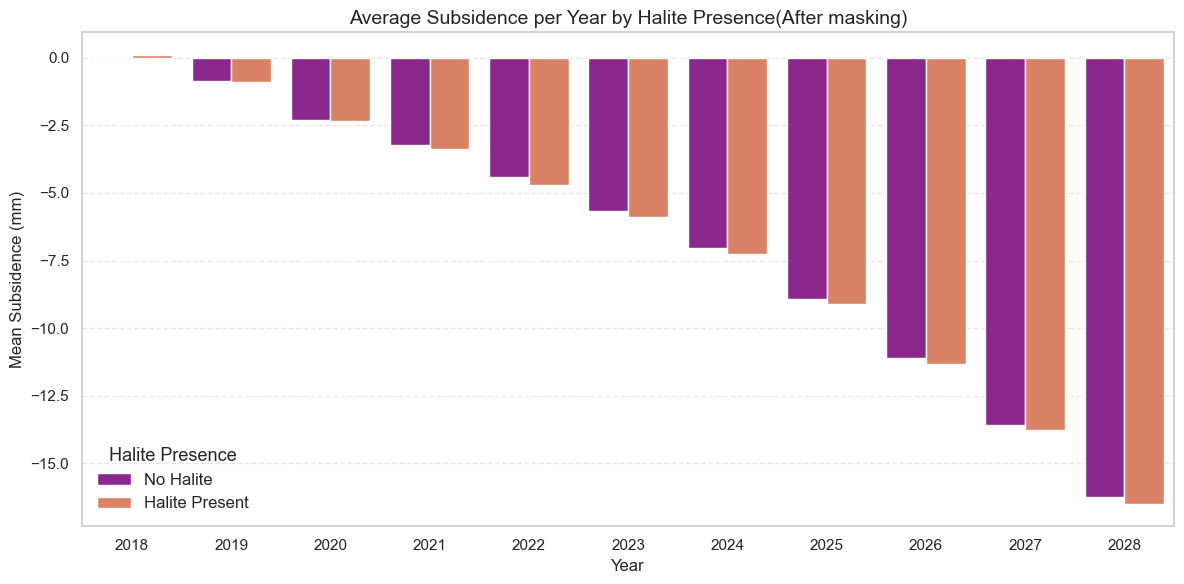

In [1249]:
plt.figure(figsize=(12, 6))
sns.barplot(
    data=summary_df2,
    x='year',
    y='mean',
    hue='halite_presence',
    palette='plasma')

handles, labels = plt.gca().get_legend_handles_labels()
labels = ["No Halite", "Halite Present"]
plt.legend(handles=handles, labels=labels, title="Halite Presence", fontsize=12, title_fontsize=13, loc='lower left')

plt.title("Average Subsidence per Year by Halite Presence(After masking)", fontsize=14)
plt.xlabel("Year", fontsize=12)
plt.ylabel("Mean Subsidence (mm)", fontsize=12)
plt.grid(True, axis='y', linestyle='--', alpha=0.5)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)

plt.tight_layout()
plt.show()

### Year Difference

In [1252]:
cumulative_df = filtered_df[['2018','2019', '2020', '2021', '2022', '2023',
                             '2024','2025', '2026', '2027', '2028']].copy()

change_df = cumulative_df.copy()
for year in ['2019', '2020', '2021', '2022', '2023', '2024', '2025', '2026', '2027', '2028']:
    prev_year = str(int(year) - 1)
    change_df[year] = cumulative_df[year] - cumulative_df[prev_year]

In [1258]:
cumulative_df

2018  2019  2020  2021  2022  2023       2024       2025       2026  \
4        0.9  -1.5  -4.8  -5.2  -5.7  -7.5  -9.408139 -11.988132 -14.445389   
13       0.6   0.5  -1.4  -2.9  -4.0  -6.1  -7.317557  -9.422470 -12.379705   
15      -0.9   1.2  -0.6  -4.7  -5.8  -8.4  -8.922837 -12.279012 -13.846469   
17       0.2  -0.3  -2.6  -6.1  -6.4  -7.2  -8.694694 -12.089329 -14.128919   
18       0.1  -0.3  -1.1  -1.4  -4.1  -5.0  -6.421299  -8.696492 -11.570835   
...      ...   ...   ...   ...   ...   ...        ...        ...        ...   
105927  -0.8   2.6   0.0  -2.3  -3.0  -4.3  -7.100084  -8.959764 -12.164756   
105988  -0.9  -2.1  -2.3  -3.3  -3.6  -3.9  -4.327158  -4.582044  -5.660773   
106108  -0.4  -0.3  -0.8  -1.4  -1.5  -2.8  -3.144760  -3.961964  -4.345362   
106151   0.3  -1.3  -3.2  -4.6  -4.8  -5.1  -6.680912  -7.683043  -9.013638   
106264  -1.9  -0.5  -2.1  -2.8  -7.6 -10.6 -12.802060 -15.567905 -18.700846   

             2027       2028  
4      -17.268127 -18.967918  
13     -15.776380 -18.602678  
15     -16.959713 -21.251310  
17     -17.076349 -18.843220  
18     -15.319518 -17.446026  
...           ...        ...  
105927 -15.497618 -19.123579  
105988  -6.752694  -7.618339  
106108  -5.191038  -6.527802  
106151 -10.960164 -12.954366  
106264 -23.456970 -25.511478  

[11768 rows x 11 columns]

In [1256]:
change_df

2018  2019  2020  2021  2022  2023      2024      2025      2026  \
4        0.9  -2.4  -3.3  -0.4  -0.5  -1.8 -1.908139 -2.579993 -2.457256   
13       0.6  -0.1  -1.9  -1.5  -1.1  -2.1 -1.217557 -2.104913 -2.957235   
15      -0.9   2.1  -1.8  -4.1  -1.1  -2.6 -0.522837 -3.356174 -1.567457   
17       0.2  -0.5  -2.3  -3.5  -0.3  -0.8 -1.494694 -3.394635 -2.039590   
18       0.1  -0.4  -0.8  -0.3  -2.7  -0.9 -1.421299 -2.275194 -2.874343   
...      ...   ...   ...   ...   ...   ...       ...       ...       ...   
105927  -0.8   3.4  -2.6  -2.3  -0.7  -1.3 -2.800084 -1.859679 -3.204992   
105988  -0.9  -1.2  -0.2  -1.0  -0.3  -0.3 -0.427158 -0.254886 -1.078729   
106108  -0.4   0.1  -0.5  -0.6  -0.1  -1.3 -0.344760 -0.817204 -0.383398   
106151   0.3  -1.6  -1.9  -1.4  -0.2  -0.3 -1.580912 -1.002131 -1.330595   
106264  -1.9   1.4  -1.6  -0.7  -4.8  -3.0 -2.202060 -2.765845 -3.132940   

            2027      2028  
4      -2.822739 -1.699791  
13     -3.396674 -2.826299  
15     -3.113244 -4.291597  
17     -2.947431 -1.766870  
18     -3.748683 -2.126508  
...          ...       ...  
105927 -3.332862 -3.625961  
105988 -1.091920 -0.865645  
106108 -0.845676 -1.336764  
106151 -1.946526 -1.994202  
106264 -4.756124 -2.054508  

[11768 rows x 11 columns]

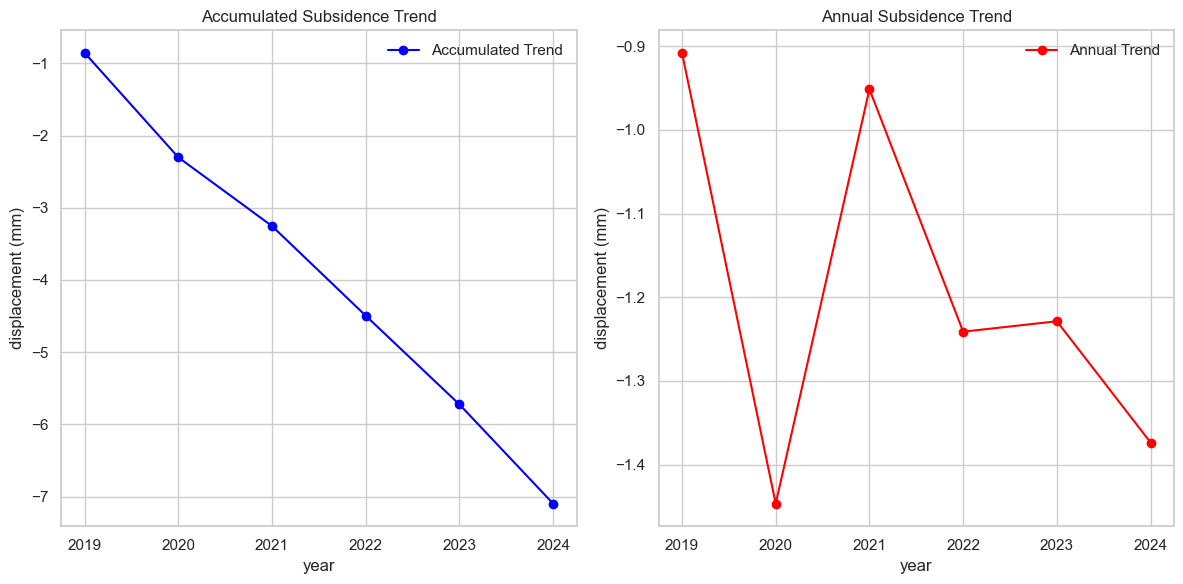

In [1262]:
###### Short-term

import matplotlib.pyplot as plt

years = ['2019', '2020', '2021', '2022', '2023', '2024']

mean_cumulative = cumulative_df[years].mean()
mean_change = change_df[years].mean()

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(years, mean_cumulative, marker='o', color='blue', label='Accumulated Trend')
plt.title('Accumulated Subsidence Trend')
plt.xlabel('year')
plt.ylabel('displacement (mm)')
plt.grid(True)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(years, mean_change, marker='o', color='red', label='Annual Trend')
plt.title('Annual Subsidence Trend')
plt.xlabel('year')
plt.ylabel('displacement (mm)')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


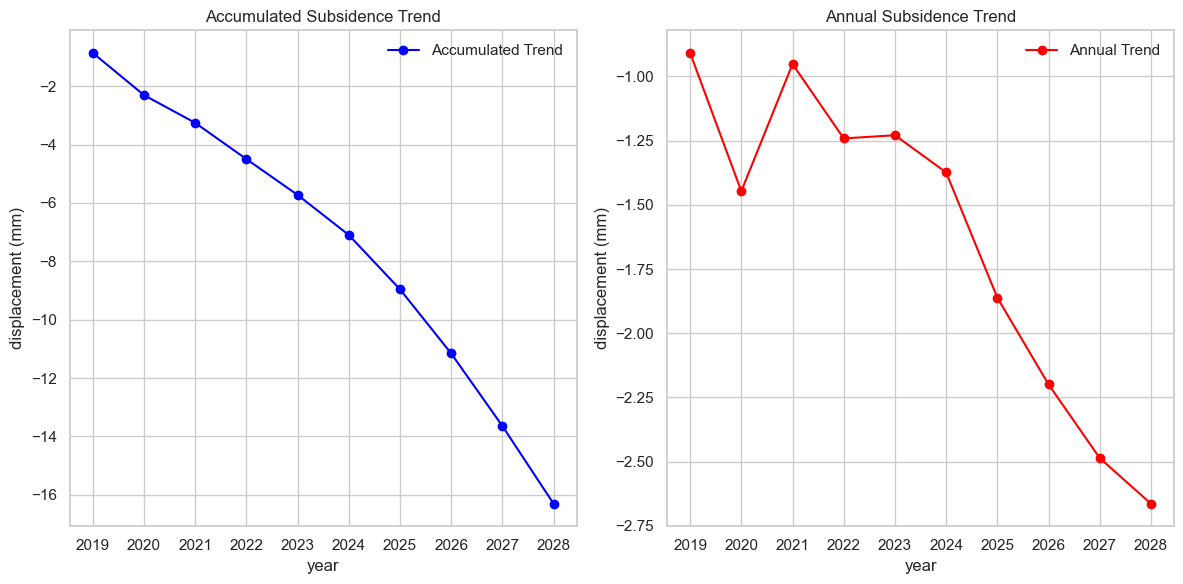

In [1260]:
###### Mid-term

import matplotlib.pyplot as plt

years = ['2019', '2020', '2021', '2022', '2023', '2024', '2025', '2026', '2027', '2028']

mean_cumulative = cumulative_df[years].mean()
mean_change = change_df[years].mean()

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(years, mean_cumulative, marker='o', color='blue', label='Accumulated Trend')
plt.title('Accumulated Subsidence Trend')
plt.xlabel('year')
plt.ylabel('displacement (mm)')
plt.grid(True)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(years, mean_change, marker='o', color='red', label='Annual Trend')
plt.title('Annual Subsidence Trend')
plt.xlabel('year')
plt.ylabel('displacement (mm)')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


## Mean annual subsidence

In [1264]:
mean_df = cumulative_df.copy() 

years = ['2018', '2019', '2020', '2021', '2022', '2023', '2024','2025', '2026', '2027', '2028']
years_trend = ['2018', '2019', '2020', '2021', '2022', '2023']
years_2024 = ['2023', '2024']
years_pred = ['2023', '2024','2025', '2026', '2027', '2028']

diff_df = mean_df[years].diff(axis=1).iloc[:, 1:] 
diff_trend = mean_df[years_trend].diff(axis=1).iloc[:, 1:]
diff_2024 = mean_df[years_2024].diff(axis=1).iloc[:, 1:]
diff_pred = mean_df[years_pred].diff(axis=1).iloc[:, 1:] 

mean_annual_subsidence = diff_df.mean().mean()
mean_annual_subsidence_trend = diff_trend.mean().mean()
mean_annual_subsidence_2024 = diff_2024.mean().mean()
mean_annual_subsidence_pred = diff_pred.mean().mean()

print(f"Mean annual subsidence: {mean_annual_subsidence:.3f} mm/yr")
print(f"Mean annual trend subsidence(2019~2023): {mean_annual_subsidence_trend:.3f} mm/yr")
print(f"Mean annual prediction subsidence(2024, short-term): {mean_annual_subsidence_2024:.3f} mm/yr")
print(f"Mean annual prediction subsidence(2024~2028, mid-term): {mean_annual_subsidence_pred:.3f} mm/yr")

Mean annual subsidence: -1.636 mm/yr
Mean annual trend subsidence(2019~2023): -1.155 mm/yr
Mean annual prediction subsidence(2024, short-term): -1.374 mm/yr
Mean annual prediction subsidence(2024~2028, mid-term): -2.117 mm/yr


In [1266]:
diff_df

2019  2020  2021  2022  2023      2024      2025      2026      2027  \
4       -2.4  -3.3  -0.4  -0.5  -1.8 -1.908139 -2.579993 -2.457256 -2.822739   
13      -0.1  -1.9  -1.5  -1.1  -2.1 -1.217557 -2.104913 -2.957235 -3.396674   
15       2.1  -1.8  -4.1  -1.1  -2.6 -0.522837 -3.356174 -1.567457 -3.113244   
17      -0.5  -2.3  -3.5  -0.3  -0.8 -1.494694 -3.394635 -2.039590 -2.947431   
18      -0.4  -0.8  -0.3  -2.7  -0.9 -1.421299 -2.275194 -2.874343 -3.748683   
...      ...   ...   ...   ...   ...       ...       ...       ...       ...   
105927   3.4  -2.6  -2.3  -0.7  -1.3 -2.800084 -1.859679 -3.204992 -3.332862   
105988  -1.2  -0.2  -1.0  -0.3  -0.3 -0.427158 -0.254886 -1.078729 -1.091920   
106108   0.1  -0.5  -0.6  -0.1  -1.3 -0.344760 -0.817204 -0.383398 -0.845676   
106151  -1.6  -1.9  -1.4  -0.2  -0.3 -1.580912 -1.002131 -1.330595 -1.946526   
106264   1.4  -1.6  -0.7  -4.8  -3.0 -2.202060 -2.765845 -3.132940 -4.756124   

            2028  
4      -1.699791  
13     -2.826299  
15     -4.291597  
17     -1.766870  
18     -2.126508  
...          ...  
105927 -3.625961  
105988 -0.865645  
106108 -1.336764  
106151 -1.994202  
106264 -2.054508  

[11768 rows x 10 columns]

In [1287]:
df_2019 = pd.concat([diff_df['2019'], filtered_df[['easting', 'northing']]], axis=1)
df_2020 = pd.concat([diff_df['2020'], filtered_df[['easting', 'northing']]], axis=1)
df_2021 = pd.concat([diff_df['2021'], filtered_df[['easting', 'northing']]], axis=1)
df_2022 = pd.concat([diff_df['2022'], filtered_df[['easting', 'northing']]], axis=1)
df_2023 = pd.concat([diff_df['2023'], filtered_df[['easting', 'northing']]], axis=1)
df_2024 = pd.concat([diff_df['2024'], filtered_df[['easting', 'northing']]], axis=1)
df_2025 = pd.concat([diff_df['2025'], filtered_df[['easting', 'northing']]], axis=1)
df_2026 = pd.concat([diff_df['2026'], filtered_df[['easting', 'northing']]], axis=1)
df_2027 = pd.concat([diff_df['2027'], filtered_df[['easting', 'northing']]], axis=1)
df_2028 = pd.concat([diff_df['2028'], filtered_df[['easting', 'northing']]], axis=1)

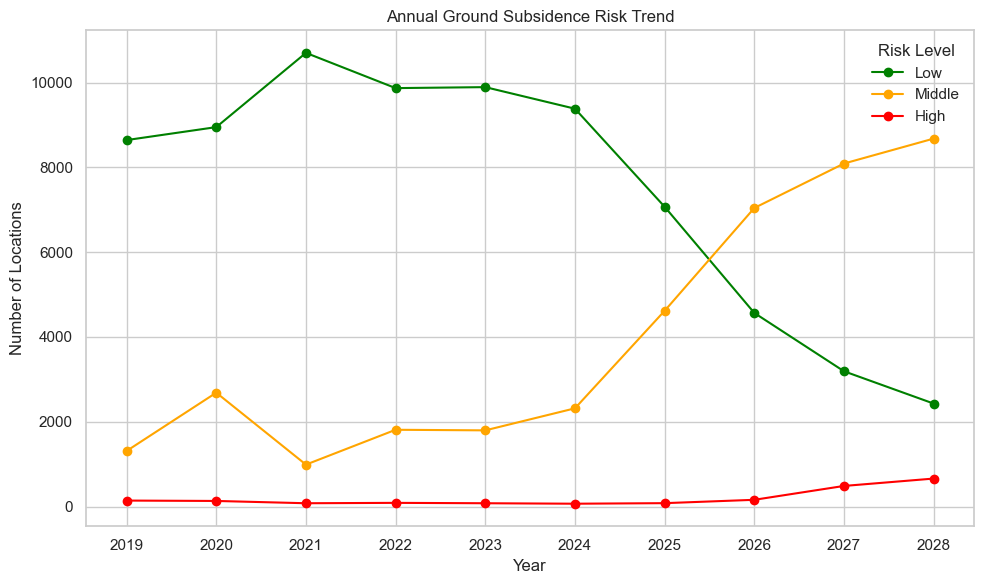

In [1270]:
import pandas as pd
import matplotlib.pyplot as plt

years = ['2019', '2020', '2021', '2022', '2023', '2024', '2025', '2026', '2027', '2028']

def classify_risk(x):
    if -2 < x <= 0:
        return 'low'
    elif -4 < x <= -2:
        return 'middle'
    elif x <= -4:
        return 'high'
    else:
        return 'other'

risk_counts = {'low': [], 'middle': [], 'high': []}

for year in years:
    col = diff_df[year]
    risk_class = col.apply(classify_risk)
    for level in ['low', 'middle', 'high']:
        count = (risk_class == level).sum()
        risk_counts[level].append(count)

plt.figure(figsize=(10, 6))
for level, color in zip(['low', 'middle', 'high'], ['green', 'orange', 'red']):
    plt.plot(years, risk_counts[level], marker='o', label=level.capitalize(), color=color)

plt.title("Annual Ground Subsidence Risk Trend")
plt.xlabel("Year")
plt.ylabel("Number of Locations")
plt.grid(True)
plt.legend(title="Risk Level")
plt.tight_layout()
plt.show()


## Halite Distinction

In [1179]:
filtered_df

pid  halite_presence  2018  2019  2020  2021  2022  2023  \
4       40fRFvdGkt                0   0.9  -1.5  -4.8  -5.2  -5.7  -7.5   
13      40fRFvdGku                0   0.6   0.5  -1.4  -2.9  -4.0  -6.1   
15      40fRTzd0L6                0  -0.9   1.2  -0.6  -4.7  -5.8  -8.4   
17      40fRdMxUjE                0   0.2  -0.3  -2.6  -6.1  -6.4  -7.2   
18      40fQeQJJCP                0   0.1  -0.3  -1.1  -1.4  -4.1  -5.0   
...            ...              ...   ...   ...   ...   ...   ...   ...   
105927  40fQxAyI3L                1  -0.8   2.6   0.0  -2.3  -3.0  -4.3   
105988  40fSSwHBwg                0  -0.9  -2.1  -2.3  -3.3  -3.6  -3.9   
106108  40fRBEy1dg                1  -0.4  -0.3  -0.8  -1.4  -1.5  -2.8   
106151  40fOub0fnn                1   0.3  -1.3  -3.2  -4.6  -4.8  -5.1   
106264  40fSqNbPvS                0  -1.9  -0.5  -2.1  -2.8  -7.6 -10.6   

        height_scaled  acceleration_scaled  rmse_scaled  seasonality_scaled  \
4           -0.544726             0.208687    -0.656197           -1.041527   
13          -0.555460            -1.027864    -0.540831            0.354617   
15          -0.540126             0.109762     0.382099           -0.243730   
17          -0.556994            -0.285934     0.151367           -0.443179   
18          -0.460387            -0.582706    -0.886930            0.952964   
...               ...                  ...          ...                 ...   
105927      -0.084695            -1.374098     0.151367           -0.243730   
105988      -0.196636             0.851693    -0.771563           -1.041527   
106108      -0.089295             0.332342    -0.886930           -0.243730   
106151       0.117719             1.049541    -0.540831           -0.842078   
106264       0.042580            -2.165490    -0.540831           -0.642629   

        easting  northing       2024       2025       2026       2027  \
4       3464350   3397850  -9.408139 -11.988132 -14.445389 -17.268127   
13      3464450   3397850  -7.317557  -9.422470 -12.379705 -15.776380   
15      3464450   3398150  -8.922837 -12.279012 -13.846469 -16.959713   
17      3464450   3398350  -8.694694 -12.089329 -14.128919 -17.076349   
18      3464550   3397050  -6.421299  -8.696492 -11.570835 -15.319518   
...         ...       ...        ...        ...        ...        ...   
105927  3493550   3397450  -7.100084  -8.959764 -12.164756 -15.497618   
105988  3493850   3399450  -4.327158  -4.582044  -5.660773  -6.752694   
106108  3494450   3397750  -3.144760  -3.961964  -4.345362  -5.191038   
106151  3494750   3394750  -6.680912  -7.683043  -9.013638 -10.960164   
106264  3496650   3399950 -12.802060 -15.567905 -18.700846 -23.456970   

             2028  
4      -18.967918  
13     -18.602678  
15     -21.251310  
17     -18.843220  
18     -17.446026  
...           ...  
105927 -19.123579  
105988  -7.618339  
106108  -6.527802  
106151 -12.954366  
106264 -25.511478  

[11768 rows x 19 columns]

In [1273]:
## Year Difference

cumulative_df = filtered_df[['halite_presence', '2018','2019', '2020', '2021', '2022', '2023',
                             '2024','2025', '2026', '2027', '2028', 'easting','northing', 'acceleration_scaled']].copy()

change_df = cumulative_df.copy()
for year in ['2019', '2020', '2021', '2022', '2023', '2024', '2025', '2026', '2027', '2028']:
    prev_year = str(int(year) - 1)
    change_df[year] = cumulative_df[year] - cumulative_df[prev_year]

change_df

halite_presence  2018  2019  2020  2021  2022  2023      2024  \
4                     0   0.9  -2.4  -3.3  -0.4  -0.5  -1.8 -1.908139   
13                    0   0.6  -0.1  -1.9  -1.5  -1.1  -2.1 -1.217557   
15                    0  -0.9   2.1  -1.8  -4.1  -1.1  -2.6 -0.522837   
17                    0   0.2  -0.5  -2.3  -3.5  -0.3  -0.8 -1.494694   
18                    0   0.1  -0.4  -0.8  -0.3  -2.7  -0.9 -1.421299   
...                 ...   ...   ...   ...   ...   ...   ...       ...   
105927                1  -0.8   3.4  -2.6  -2.3  -0.7  -1.3 -2.800084   
105988                0  -0.9  -1.2  -0.2  -1.0  -0.3  -0.3 -0.427158   
106108                1  -0.4   0.1  -0.5  -0.6  -0.1  -1.3 -0.344760   
106151                1   0.3  -1.6  -1.9  -1.4  -0.2  -0.3 -1.580912   
106264                0  -1.9   1.4  -1.6  -0.7  -4.8  -3.0 -2.202060   

            2025      2026      2027      2028  easting  northing  \
4      -2.579993 -2.457256 -2.822739 -1.699791  3464350   3397850   
13     -2.104913 -2.957235 -3.396674 -2.826299  3464450   3397850   
15     -3.356174 -1.567457 -3.113244 -4.291597  3464450   3398150   
17     -3.394635 -2.039590 -2.947431 -1.766870  3464450   3398350   
18     -2.275194 -2.874343 -3.748683 -2.126508  3464550   3397050   
...          ...       ...       ...       ...      ...       ...   
105927 -1.859679 -3.204992 -3.332862 -3.625961  3493550   3397450   
105988 -0.254886 -1.078729 -1.091920 -0.865645  3493850   3399450   
106108 -0.817204 -0.383398 -0.845676 -1.336764  3494450   3397750   
106151 -1.002131 -1.330595 -1.946526 -1.994202  3494750   3394750   
106264 -2.765845 -3.132940 -4.756124 -2.054508  3496650   3399950   

        acceleration_scaled  
4                  0.208687  
13                -1.027864  
15                 0.109762  
17                -0.285934  
18                -0.582706  
...                     ...  
105927            -1.374098  
105988             0.851693  
106108             0.332342  
106151             1.049541  
106264            -2.165490  

[11768 rows x 15 columns]

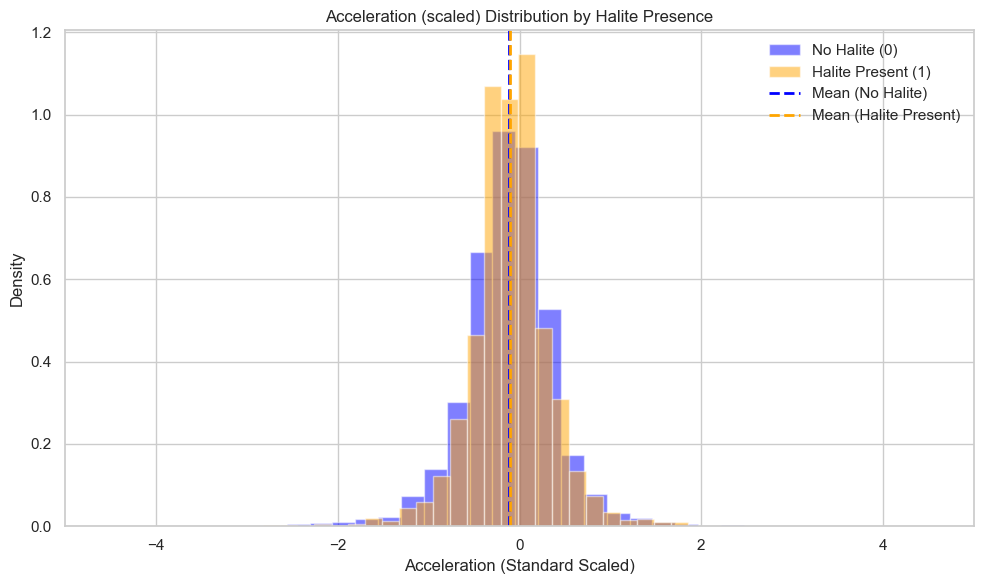

In [1275]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

no_halite = filtered_df[filtered_df['halite_presence'] == 0]['acceleration_scaled']
halite = filtered_df[filtered_df['halite_presence'] == 1]['acceleration_scaled']

plt.hist(
    filtered_df[filtered_df['halite_presence'] == 0]['acceleration_scaled'],
    bins=30, alpha=0.5, label='No Halite (0)', density=True, color='blue'
)
plt.hist(
    filtered_df[filtered_df['halite_presence'] == 1]['acceleration_scaled'],
    bins=30, alpha=0.5, label='Halite Present (1)', density=True, color='orange'
)

plt.axvline(no_halite.mean(), color='blue', linestyle='dashed', linewidth=2, label='Mean (No Halite)')
plt.axvline(halite.mean(), color='orange', linestyle='dashed', linewidth=2, label='Mean (Halite Present)')

plt.title('Acceleration (scaled) Distribution by Halite Presence')
plt.xlabel('Acceleration (Standard Scaled)')
plt.xlim(-5, 5)
plt.ylabel('Density')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

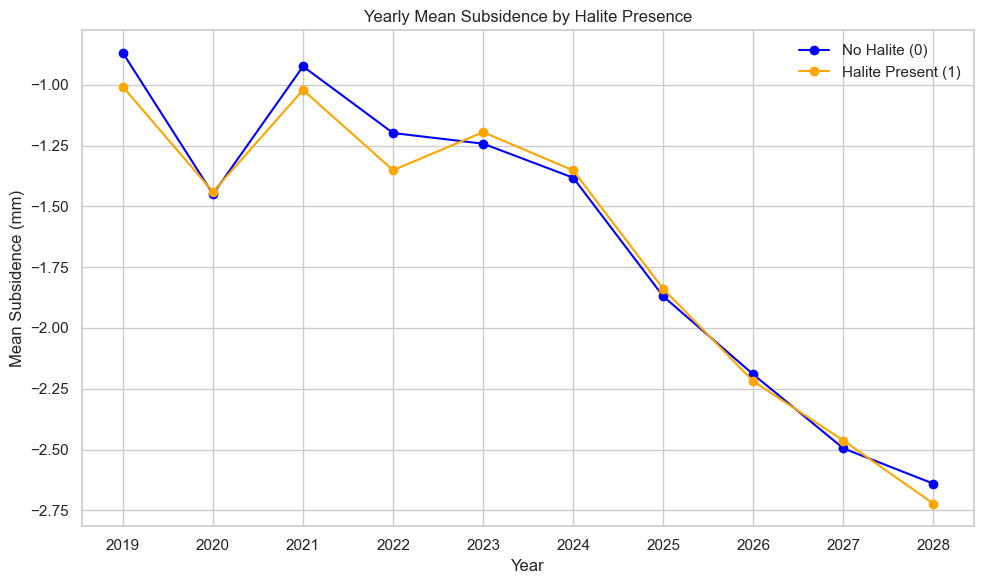

In [1277]:
year_cols = [str(y) for y in years]

mean_by_group = change_df.groupby('halite_presence')[year_cols].mean()

plt.figure(figsize=(10, 6))

plt.plot(years, mean_by_group.loc[0], label='No Halite (0)', marker='o', color='blue')
plt.plot(years, mean_by_group.loc[1], label='Halite Present (1)', marker='o', color='orange')

plt.title('Yearly Mean Subsidence by Halite Presence')
plt.xlabel('Year')
plt.ylabel('Mean Subsidence (mm)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [1279]:
importances = model_xgb.feature_importances_
feature_names = X.columns  

importance_features = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values(by='importance', ascending=False)

print(importance_features.head(10))

                 feature  importance
71      rolling_mean_12m    0.602623
63       rolling_mean_3m    0.092037
75      rolling_mean_24m    0.061962
92  mean_velocity_scaled    0.048499
67       rolling_mean_6m    0.023988
79      rolling_mean_36m    0.023396
3                  lag_5    0.018868
74       rolling_min_12m    0.015771
65        rolling_max_3m    0.006649
13                lag_55    0.005606


## Forium + HS2

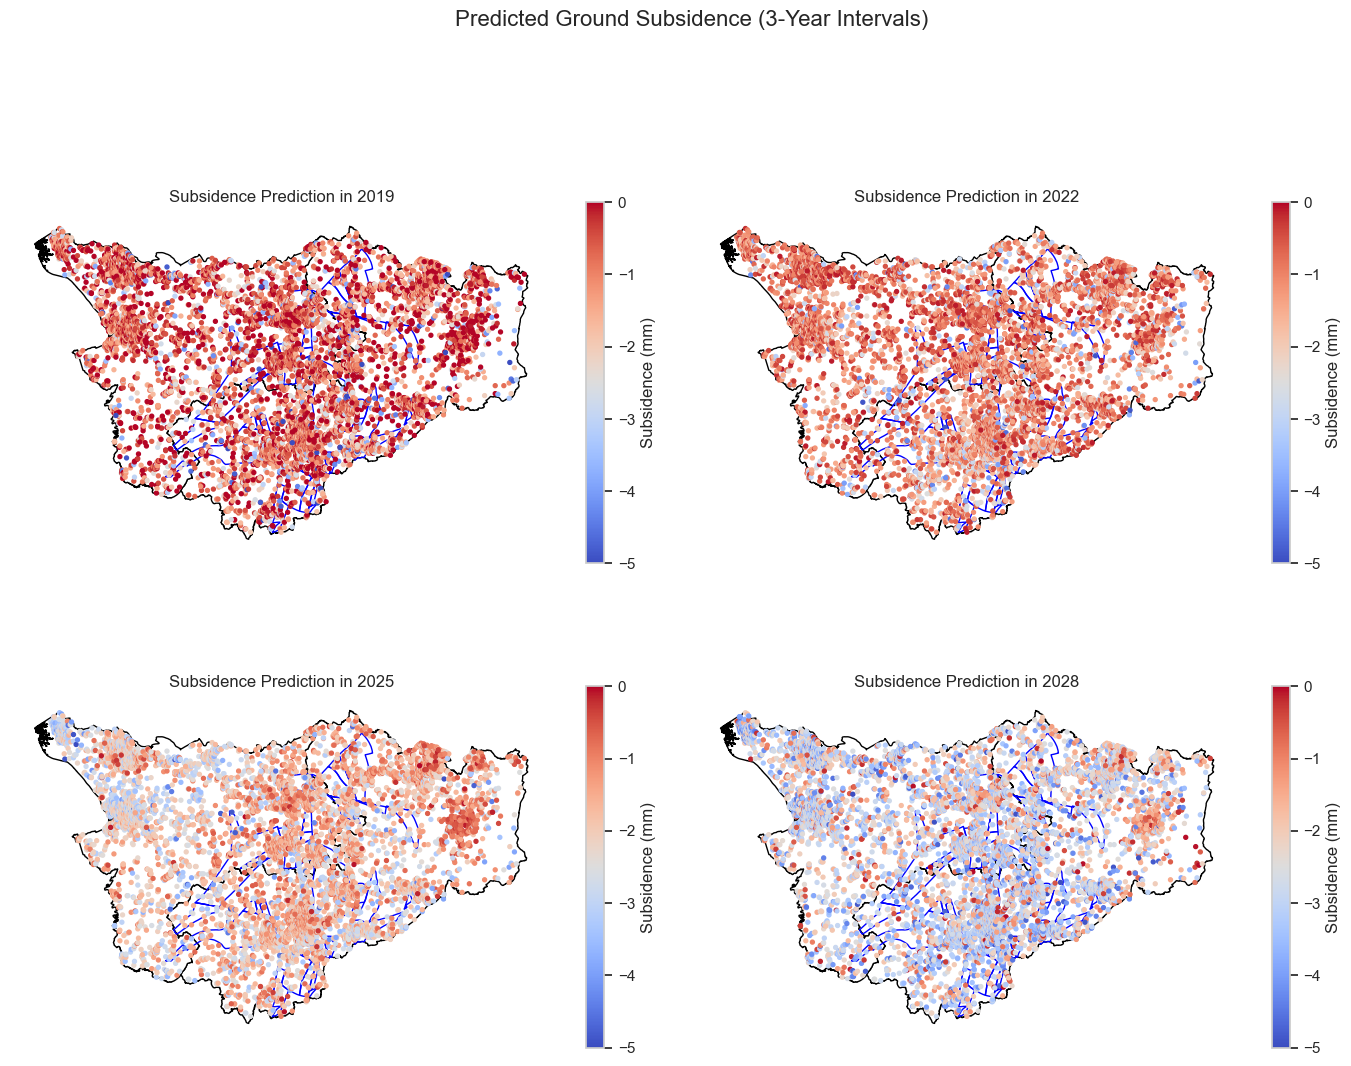

In [1301]:
years = list(range(2019, 2029, 3))  # 2018~2028, 3yrs term

vmin = -5
vmax = 0

fig, axs = plt.subplots(2, 2, figsize=(14, 12))
for idx, year in enumerate(years):
    ax = axs[idx // 2, idx % 2]
    
    gdf_year = gpd.GeoDataFrame(
        change_df,
        geometry=gpd.points_from_xy(change_df['easting'], change_df['northing']),
        crs="EPSG:3035"
    )
    gdf_year = gdf_year[gdf_year.geometry.within(cheshire_union)]

    cheshire.plot(ax=ax, color='white', edgecolor='black', linewidth=1)
    halite_within_cheshire.plot(ax=ax, color='none', edgecolor='blue', linewidth=1, label='Halite Zones')

    gdf_year.plot(
        ax=ax,
        column=str(year),
        cmap='coolwarm',
        markersize=8,
        legend=True,
        vmin=vmin,
        vmax=vmax,
        legend_kwds={'label': f'Subsidence (mm)', 'shrink': 0.6}
    )

    ax.set_title(f"Subsidence Prediction in {year}")
    ax.set_aspect('equal')
    ax.axis('off')

plt.suptitle("Predicted Ground Subsidence (3-Year Intervals)", fontsize=16)
plt.tight_layout()
plt.subplots_adjust(top=0.92)
plt.show()

## JSON, CSV File creation

In [1289]:
df_2019.to_csv("df_2019.csv", index=False)
df_2020.to_csv("df_2020.csv", index=False)
df_2021.to_csv("df_2021.csv", index=False)
df_2022.to_csv("df_2022.csv", index=False)
df_2023.to_csv("df_2023.csv", index=False)
df_2024.to_csv("df_2024.csv", index=False)
df_2025.to_csv("df_2025.csv", index=False)
df_2026.to_csv("df_2026.csv", index=False)
df_2027.to_csv("df_2027.csv", index=False)
df_2028.to_csv("df_2028.csv", index=False)

In [1291]:
gdf = gpd.GeoDataFrame(
        df_2019,
        geometry=gpd.points_from_xy(filtered_df['easting'], filtered_df['northing']),
        crs="EPSG:3035")

gdf.to_file("df_2019.geojson", driver="GeoJSON")

gdf = gpd.GeoDataFrame(
        df_2020,
        geometry=gpd.points_from_xy(filtered_df['easting'], filtered_df['northing']),
        crs="EPSG:3035")

gdf.to_file("df_2020.geojson", driver="GeoJSON")

gdf = gpd.GeoDataFrame(
        df_2021,
        geometry=gpd.points_from_xy(filtered_df['easting'], filtered_df['northing']),
        crs="EPSG:3035")

gdf.to_file("df_2021.geojson", driver="GeoJSON")

gdf = gpd.GeoDataFrame(
        df_2022,
        geometry=gpd.points_from_xy(filtered_df['easting'], filtered_df['northing']),
        crs="EPSG:3035")

gdf.to_file("df_2022.geojson", driver="GeoJSON")

gdf = gpd.GeoDataFrame(
        df_2023,
        geometry=gpd.points_from_xy(filtered_df['easting'], filtered_df['northing']),
        crs="EPSG:3035")

gdf.to_file("df_2023.geojson", driver="GeoJSON")

gdf = gpd.GeoDataFrame(
        df_2024,
        geometry=gpd.points_from_xy(filtered_df['easting'], filtered_df['northing']),
        crs="EPSG:3035")

gdf.to_file("df_2024.geojson", driver="GeoJSON")

gdf = gpd.GeoDataFrame(
        df_2025,
        geometry=gpd.points_from_xy(filtered_df['easting'], filtered_df['northing']),
        crs="EPSG:3035")

gdf.to_file("df_2025.geojson", driver="GeoJSON")

gdf = gpd.GeoDataFrame(
        df_2026,
        geometry=gpd.points_from_xy(filtered_df['easting'], filtered_df['northing']),
        crs="EPSG:3035")

gdf.to_file("df_2026.geojson", driver="GeoJSON")

gdf = gpd.GeoDataFrame(
        df_2027,
        geometry=gpd.points_from_xy(filtered_df['easting'], filtered_df['northing']),
        crs="EPSG:3035")

gdf.to_file("df_2027.geojson", driver="GeoJSON")

gdf = gpd.GeoDataFrame(
        df_2028,
        geometry=gpd.points_from_xy(filtered_df['easting'], filtered_df['northing']),
        crs="EPSG:3035")

gdf.to_file("df_2028.geojson", driver="GeoJSON")
